# Research Report: Statistical Foundation of Machine Learning
Group members:
- Stefano Claes (Applied IT): 0546268
- Femke Geens (AI): 0544174
- Liam Mertens (AI): 0564179

# Imports

In [14]:
from matplotlib import pyplot as plt
from scipy.stats import randint
import pandas as pd
import gc
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score , f1_score
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn import linear_model

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_moons, make_blobs, make_circles
from imblearn.pipeline import make_pipeline
import os
import joblib as jl
import librosa
from IPython.display import Audio
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress ba


import random
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import IPython.display as ipd


import cv2

In [15]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
import librosa
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from audiomentations import *
from albumentations.core.transforms_interface import DualTransform, BasicTransform



from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K



# import Deep learning Libraries
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D ,Input, InputLayer, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.vgg19 import VGG19

import albumentations as A
#
import lightgbm as lgb

from lightgbm import LGBMRegressor

import optuna

from lazypredict.Supervised import LazyRegressor


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from skimage import filters, feature
from skimage.io import imread, imshow

import tensorflow as tf
import pandas as pd
import numpy as np

In [20]:
import soundfile




# 1. What is the model improvement of data-augmentation in regards to different types of data? (audio,images,tabular,tabular (low-dimensionalty))

## 1.1 Creation of synthetic data
The first form of used synthetic data is build upon the generation of random dots in a 2 dimensional plane. The 2 groups of data are generated in 2 groups that are contained within 2 rectangles of data.

In [5]:
def generate_experiment_block_data(low_x1,low_x2,high_x1,high_x2,low_y1,low_y2,high_y1,high_y2,imbalance,amount_of_samples):
    amount_of_samples = 100
    low_x1, high_x1 = 33,64
    low_y1, high_y1 = 0,16
    low_x2, high_x2 = 0,32
    low_y2, high_y2 = 0,16

    rx_1 = randint.rvs(low_x1, high_x1, size=int(amount_of_samples))
    ry_1 = randint.rvs(low_y1, high_y1, size=int(amount_of_samples))
    rx_2 = randint.rvs(low_x2, high_x2, size=int(amount_of_samples/imbalance))
    ry_2 = randint.rvs(low_y2, high_y2, size=int(amount_of_samples/imbalance))
    
    group_nr0 = ["0"] * amount_of_samples
    group_nr1 = ["1"] * int(amount_of_samples/imbalance)
    
    first_group = list(zip(rx_1, ry_1, group_nr0))
    second_group = list(zip(rx_2, ry_2, group_nr1))
    
    for list_elem in second_group:
        first_group.append(list_elem)
        
    block_data = pd.DataFrame(first_group, columns  =['x', 'y', "group"])

    return block_data
    
    

    

## 1.2 Experiment setup
The experiment is done as follows, first the data is generated. Then there are 3 classification algorithms run. The first algorithm will take no measures to solve the class imbalance, the second algorithm will solve this by adjusting the class weights accordingly and the third algorithm will solve this with an algorithm called SMOTE to create extra synthetic data. All these experiments are averaged over 10 trials using a random test-train-split too have a good comparision. Every train test split was done with a halfway cut (50% train, 50% test).


Cite to SMOTE paper: https://doi.org/10.1613/jair.953



### 1.2.1 SVM-algorithm

The support vector machine algorithm works by maximizing the margin between 2 classes and using this to decide to what class a particular sample is placed. Graphically this can be interpreted as in next image:
<center> <img src="https://miro.medium.com/v2/resize:fit:921/1*06GSco3ItM3gwW2scY6Tmg.png" ></center>

Mathematically this is done a little more subtle, the $\gamma$ is chosen automatically for our SVM. "This being the parameter that defines the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’." https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
The standard SVM uses an RBF-function as kernel and can be seen below.

$$k(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \left\|\mathbf{x}_i - \mathbf{x}_j\right\|^2\right)$$

It can be observed that this function is an exponential function, this can be expanded with a Taylor-series as follows:
$$ k(x_i , x_j) = exp(- ( \vert \vert x_i \vert \vert )^2) exp(- (\vert \vert x_j \vert \vert)^2 ) \sum_{n=0}^{\infty} \frac{(2x_i^T x_j)^n}{n!}$$

Taking this into account an rbf function can map every point to an infinite dimensional space, this makes it possible to fit a hyperplane that linearly seperates the newly mapped samples.
Visually this can be interpreted as seen in the picture below:
<center> <img src="https://www.researchgate.net/publication/282920922/figure/fig2/AS:669972997083158@1536745418503/2D-input-space-mapping-into-3D-feature-space-to-separate-data-linearly.jpg" ></center>

https://stats.stackexchange.com/questions/58585/how-to-understand-effect-of-rbf-svm <br>
http://image.diku.dk/imagecanon/material/cortes_vapnik95.pdf

In [6]:

minority_class_imbalance = [2,4,8]
amount_of_samples = 150
low_x1, high_x1 = 33,64
low_y1, high_y1 = 0,16
low_x2, high_x2 = 0,32
low_y2, high_y2 = 0,16

for imbalance in minority_class_imbalance:
    average_acc_none = 0
    average_acc_rand = 0
    average_acc_sm = 0
    
    average_f1_none = 0
    average_f1_rand = 0
    average_f1_sm = 0
    
    
    
    print("imbalance #class1/#class2")
    print(imbalance)
    for random_data in range(0,10):
        block_data = generate_experiment_block_data(33,0,64,32,0,0,16,16,imbalance,amount_of_samples)
        # Take the average over several train-test-splits
        for random_state_idx in range(0,10):

            train, test = train_test_split(block_data, test_size=0.5, random_state= random_state_idx)
            X_train = train.drop(['group'], axis=1)
            X_test = test.drop(['group'], axis=1)

            y_train = train['group']
            y_test = test['group']


            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)
            y_pred =  clf.predict(X_test)
            average_acc_none = accuracy_score(y_pred, y_test) + average_acc_none
            average_f1_none = f1_score(y_pred, y_test,  pos_label="1") + average_f1_none

            ros = RandomOverSampler(random_state=42)
            X_res_rand, y_res_rand = ros.fit_resample(X_train, y_train)
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_res_rand, y_res_rand)
            y_pred =  clf.predict(X_test)
            average_acc_rand = accuracy_score(y_pred, y_test) + average_acc_rand
            average_f1_rand = f1_score(y_pred, y_test, pos_label="1") + average_f1_rand

            sm = SMOTE(random_state=42, k_neighbors=3)
            X_res_sm, y_res_sm = sm.fit_resample(X_train, y_train)
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_res_sm, y_res_sm)
            y_pred =  clf.predict(X_test)
            average_acc_sm = accuracy_score(y_pred, y_test) + average_acc_sm
            average_f1_sm = f1_score(y_pred, y_test, pos_label="1") + average_f1_sm


    print("Averaged score for no resampling: ")
    print(average_acc_none/100)

    print("Averaged score for rand resampling: ")
    print(average_acc_rand/100)

    print("Averaged score for smote resampling: ")
    print(average_acc_sm/100)
    
    
    print("f1 score for no resampling: ")
    print(average_f1_none/100)

    print("f1 score for rand resampling: ")
    print(average_f1_rand/100)

    print("f1 score for smote resampling: ")
    print(average_f1_sm/100)



    

imbalance #class1/#class2
2
Averaged score for no resampling: 
0.973066666666666
Averaged score for rand resampling: 
0.973466666666666
Averaged score for smote resampling: 
0.9743999999999996
f1 score for no resampling: 
0.955536759874408
f1 score for rand resampling: 
0.959184773395828
f1 score for smote resampling: 
0.9598574741663098
imbalance #class1/#class2
4
Averaged score for no resampling: 
0.9753968253968246
Averaged score for rand resampling: 
0.9769841269841264
Averaged score for smote resampling: 
0.9792063492063485
f1 score for no resampling: 
0.9274426034137508
f1 score for rand resampling: 
0.9403097701345842
f1 score for smote resampling: 
0.9430044928707274
imbalance #class1/#class2
8
Averaged score for no resampling: 
0.9828571428571428
Averaged score for rand resampling: 
0.9751785714285718
Averaged score for smote resampling: 
0.9817857142857142
f1 score for no resampling: 
0.8695576090576087
f1 score for rand resampling: 
0.8453477013182894
f1 score for smote resa

* Note when rerunning the experiment, scores may vary
* Scores are based on the accuracy-score: $\frac{True_{neg} + True_{pos}}{True_{pos} + False_{neg} + True_{neg} + False_{pos}}$
| Accuracy   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.971  | 0.973  | 0.971  |
| Class imbalance 1/4   | 0.974  | 0.967  | 0.972  |
| Class imbalance 1/8   | 0.980  | 0.967  | 0.976  |

Using these observations, there is always a benefit by never solving the imbalance and fitting the clasifier with the data as is.




To have a score-function that takes more the class imbalance into account we use the f1-score as a scoring function, this has following results:
$$ Precision = \frac{ True_{pos} }{ True_{pos} + False_{pos} } $$

$$ Recall = \frac{True_{pos}}{True_{pos} + False_{neg}} $$

$$F_1 = 2 *  \frac{Precision * Recall}{Precision + Recall}$$


<center> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png"  width="300" height="150"></center>

* Note that each time we based the f1-score on the minority class.

| f1-score   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.962  | 0.966  | 0.968  |
| Class imbalance 1/4   | 0.933  | 0.923  | 0.934  |
| Class imbalance 1/8   | 0.849  | 0.845  | 0.861  |

Using the f1-scoring it can be seen that SMOTE-resampling performs better in all 3 occasions, with more gain at higher rates of imbalance.

## 1.3 Creation of synthetic data (Using sklearn)
 To continue the research in low dimensional data again a support vector machine was used to do the classification. This time however the data is generated with sklearn their inbuild data generators. 

In [7]:
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

Above code is retrieved from sklearn.

### 1.3.1 Standard scaling features

Standard scaling will take a feature from a sample and apply following formula:
$$z = \frac{x- \mu}{std}$$
This will essentially center all data arround 0 and will generate a standard deviation of 1.

Graphically the figure below show this scaling on some data:
<center> <img src="https://curiousily.com/static/a80c38e5599b1367029c22a94bd30978/3e3fe/standard-scaling.png" ></center>

## 1.4 Experiment setup
The experiment contains several for loops each with their own function, this being:
- The imbalance rate.
- The type of dataset using a certain imbalance rate.
- A certain pipeline containing a scaler, an optional oversampler and a classifier.
- A loop for performing several random splits to generalize the experiment.

The experiment is based on following pipeline parameters:
- The imbalance rate is fixed to 1/2th , 1/4th and 1/8th of the majority class. 
- A StandardScaler is used to scale the data. 
- A support vector machine is used to perform the classification. 
- For each experiment the majority class contains 300 samples. 

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
Imbalance rate: 
2
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
Type of dataset: 
moons
-------------------------------------------------------------------------------------------------------
Type of oversampler:
No sampling
-------------------------------------------------------------------------------------------------------
Type of oversampler:
Random sampler
--------------------------------------------------------

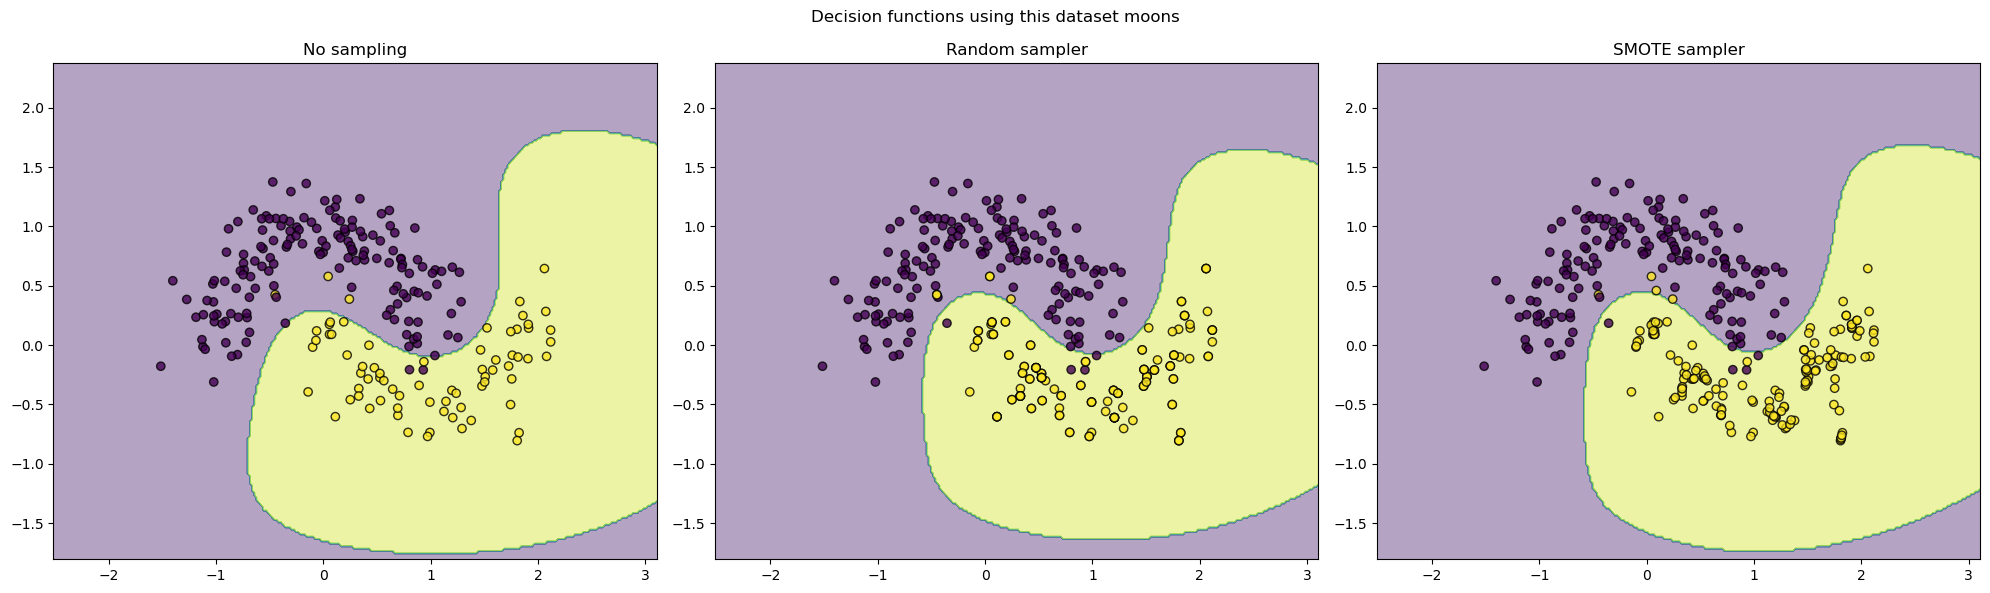

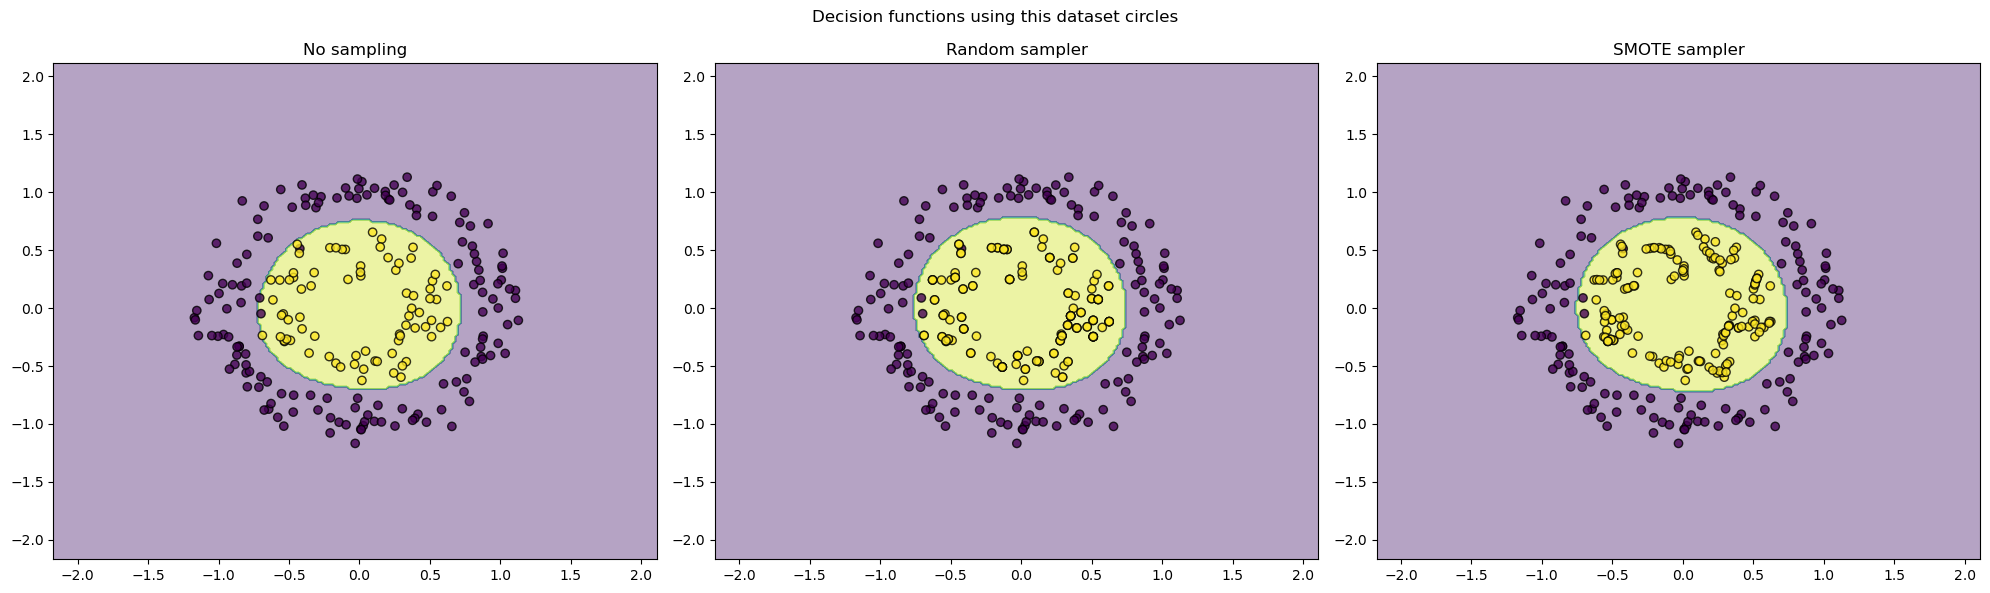

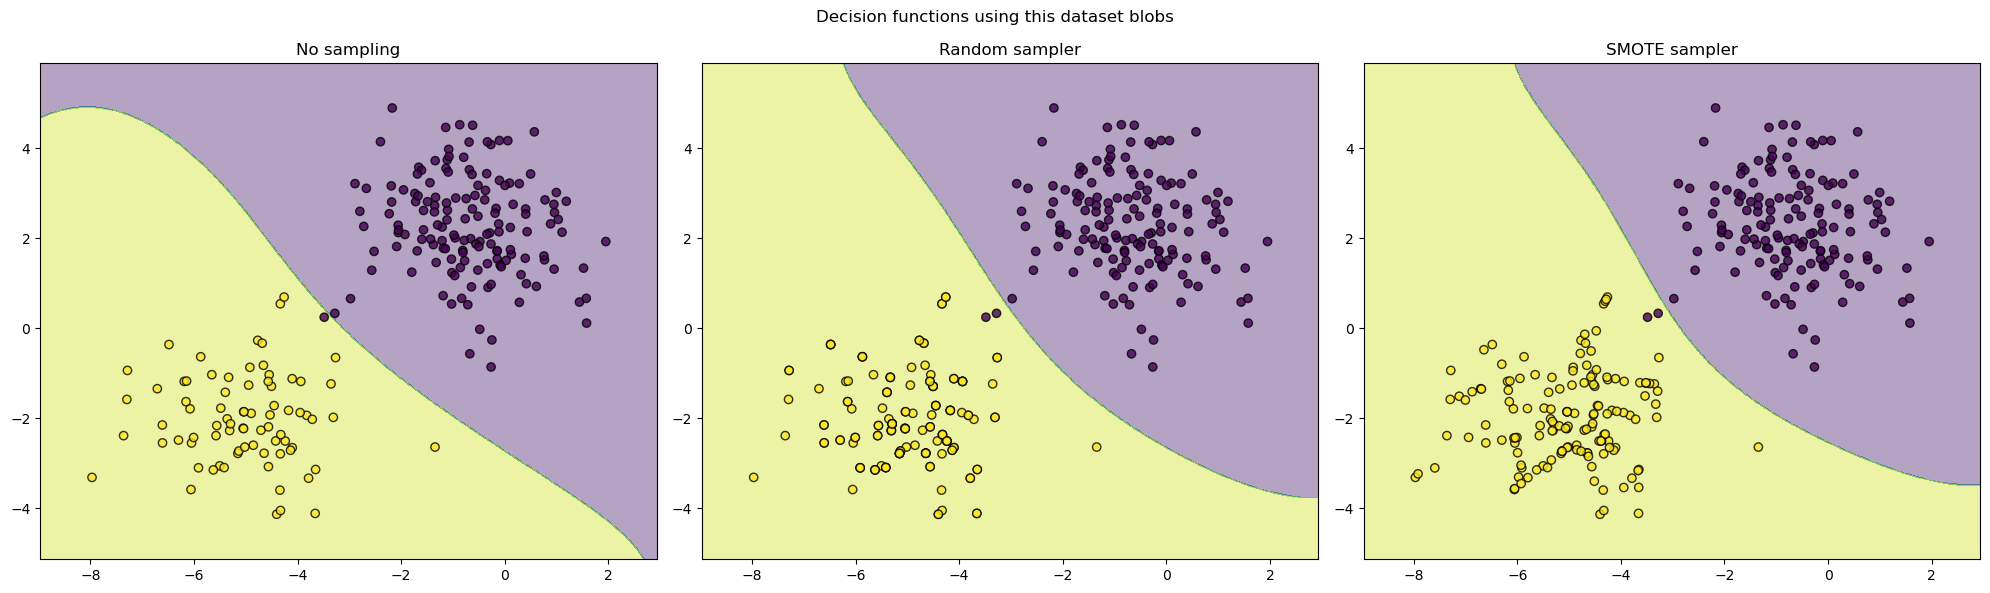

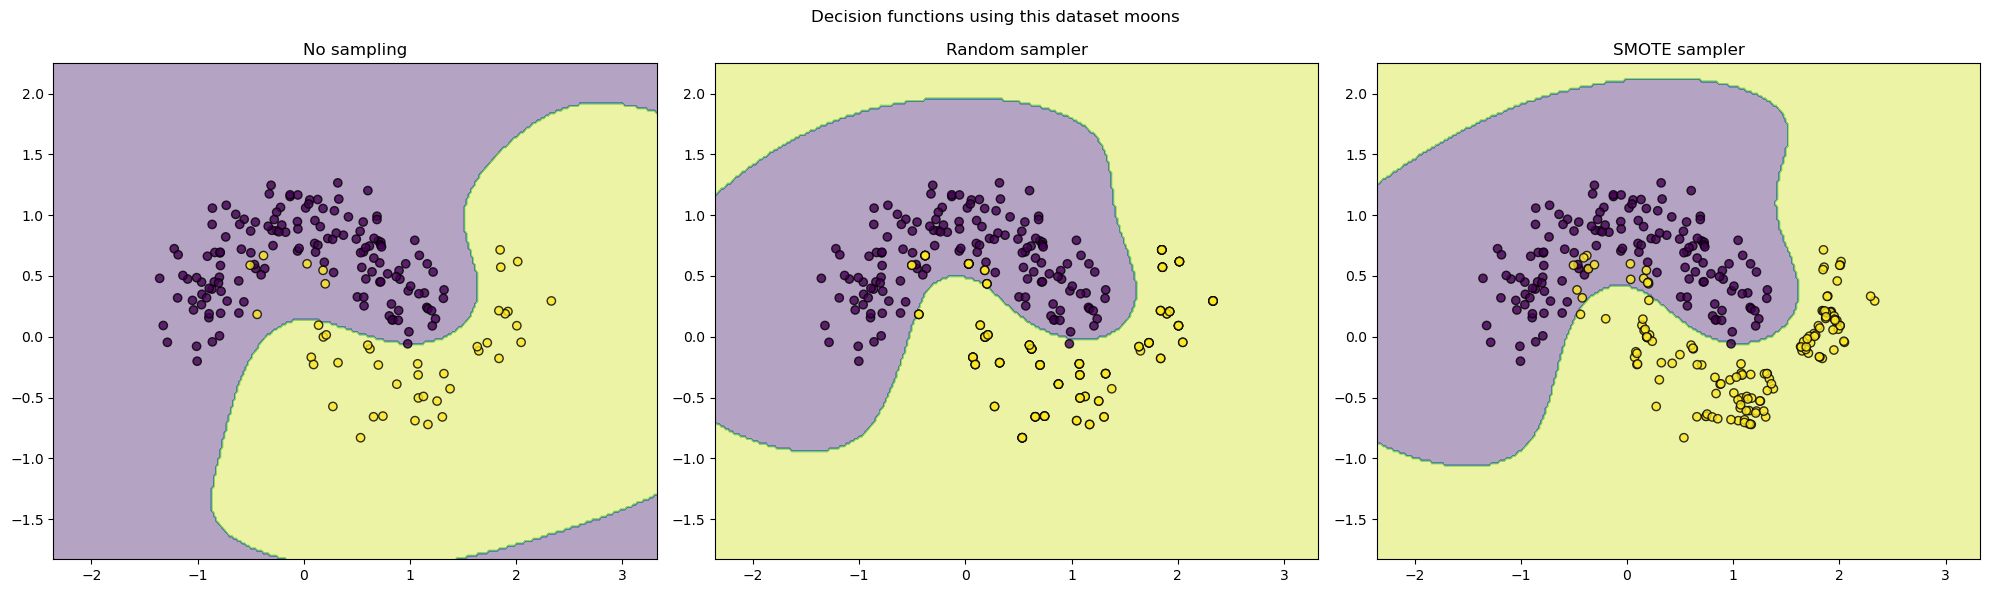

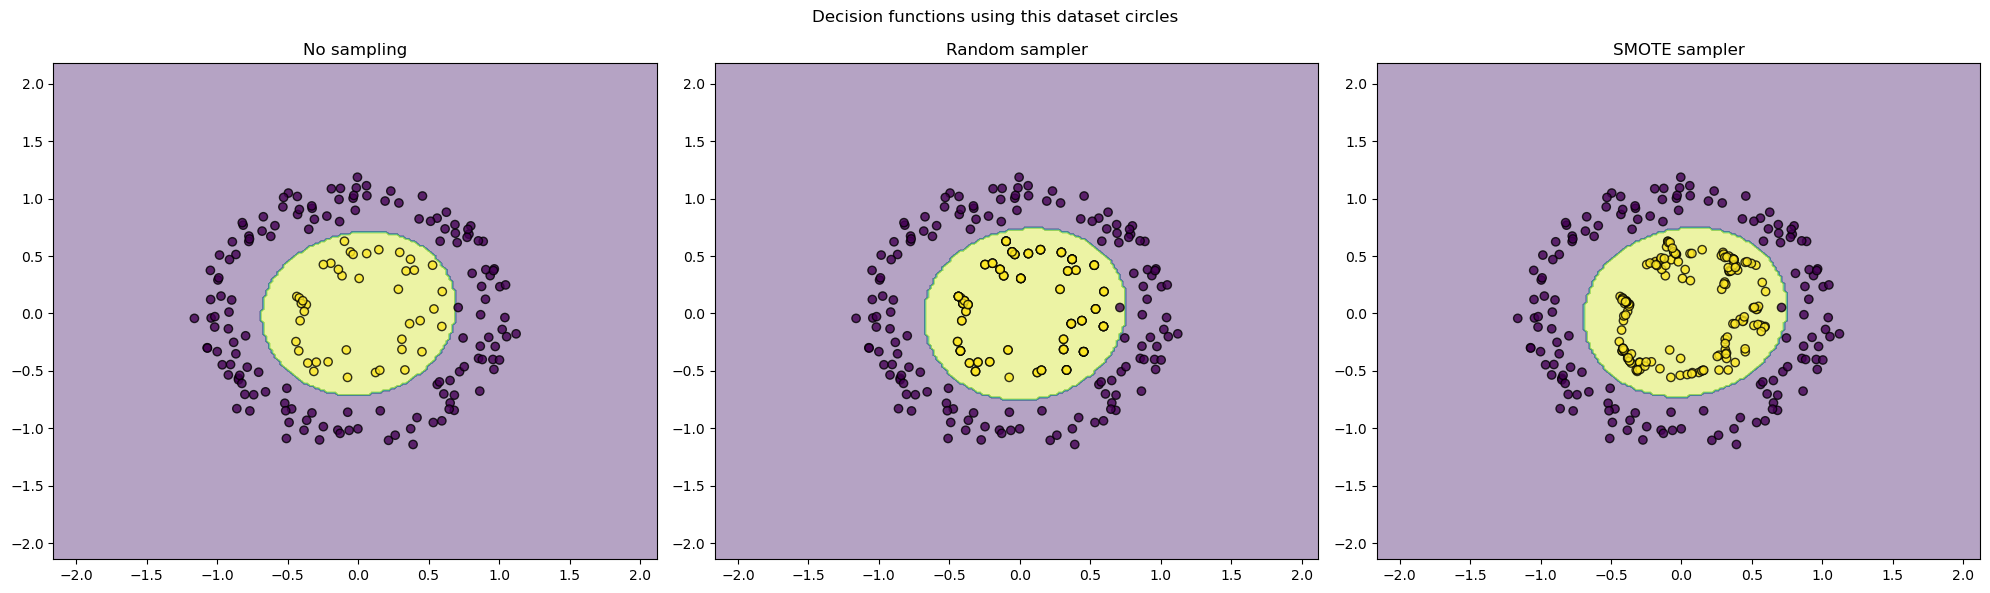

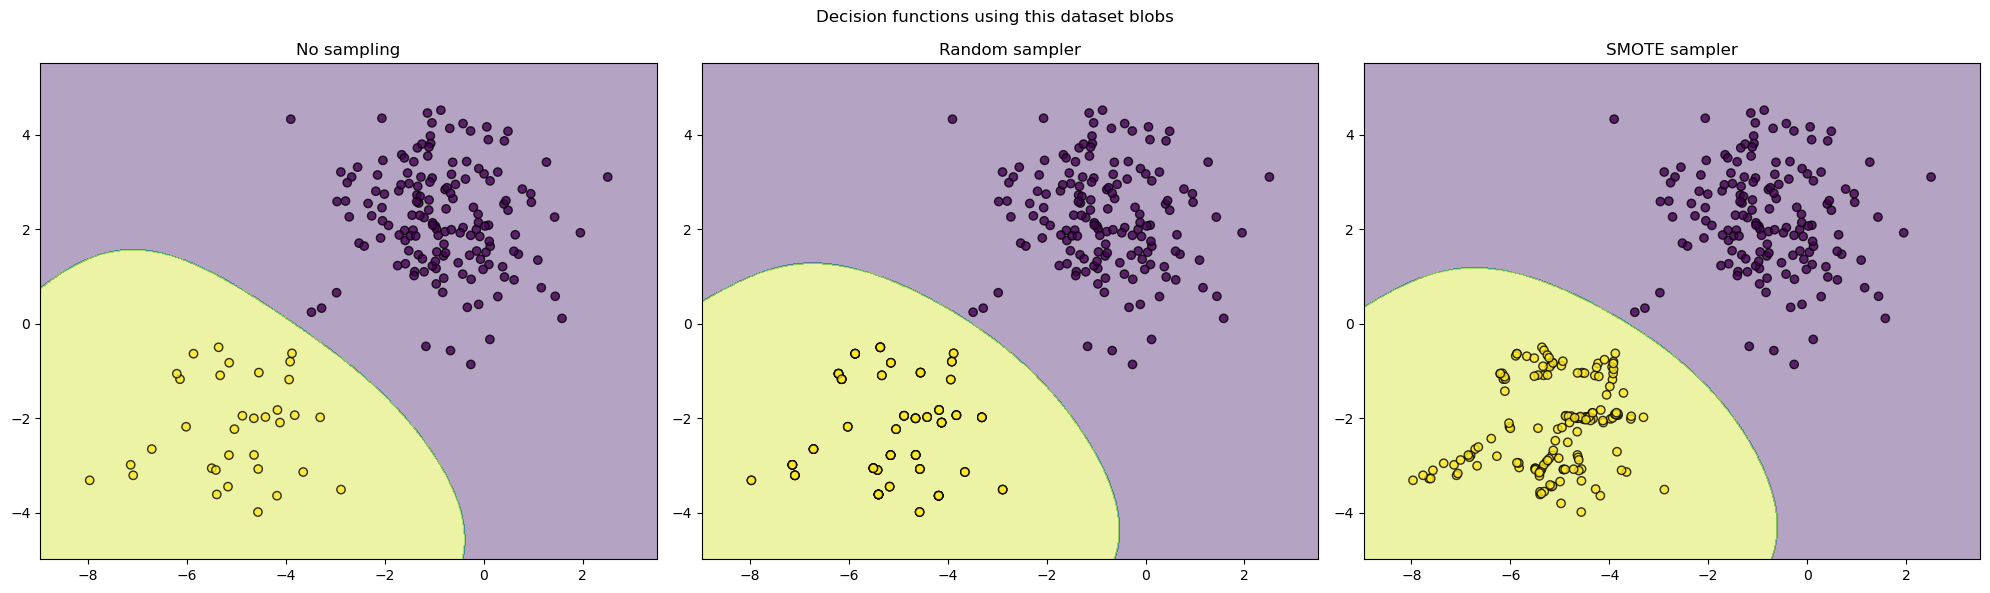

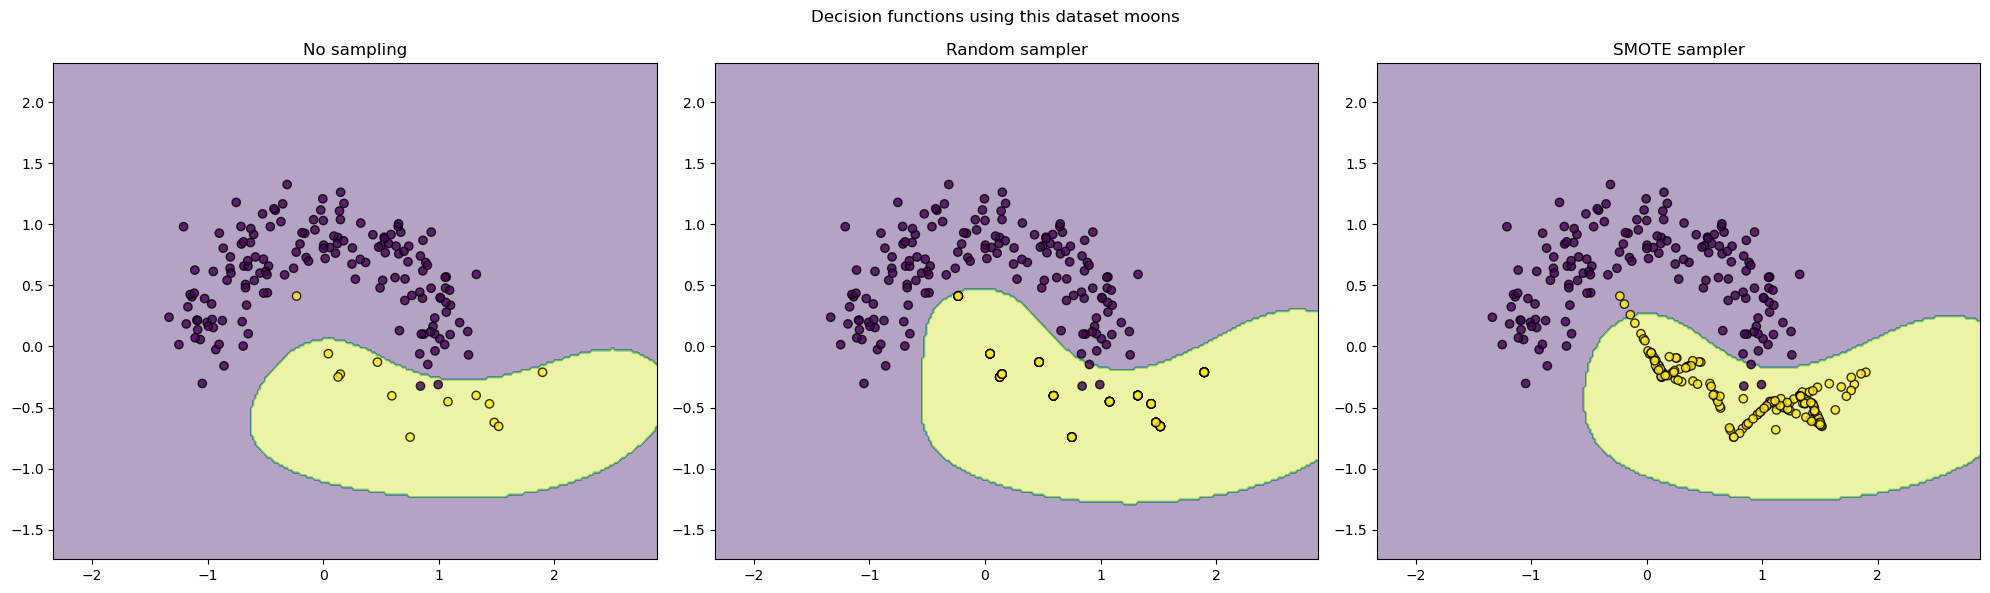

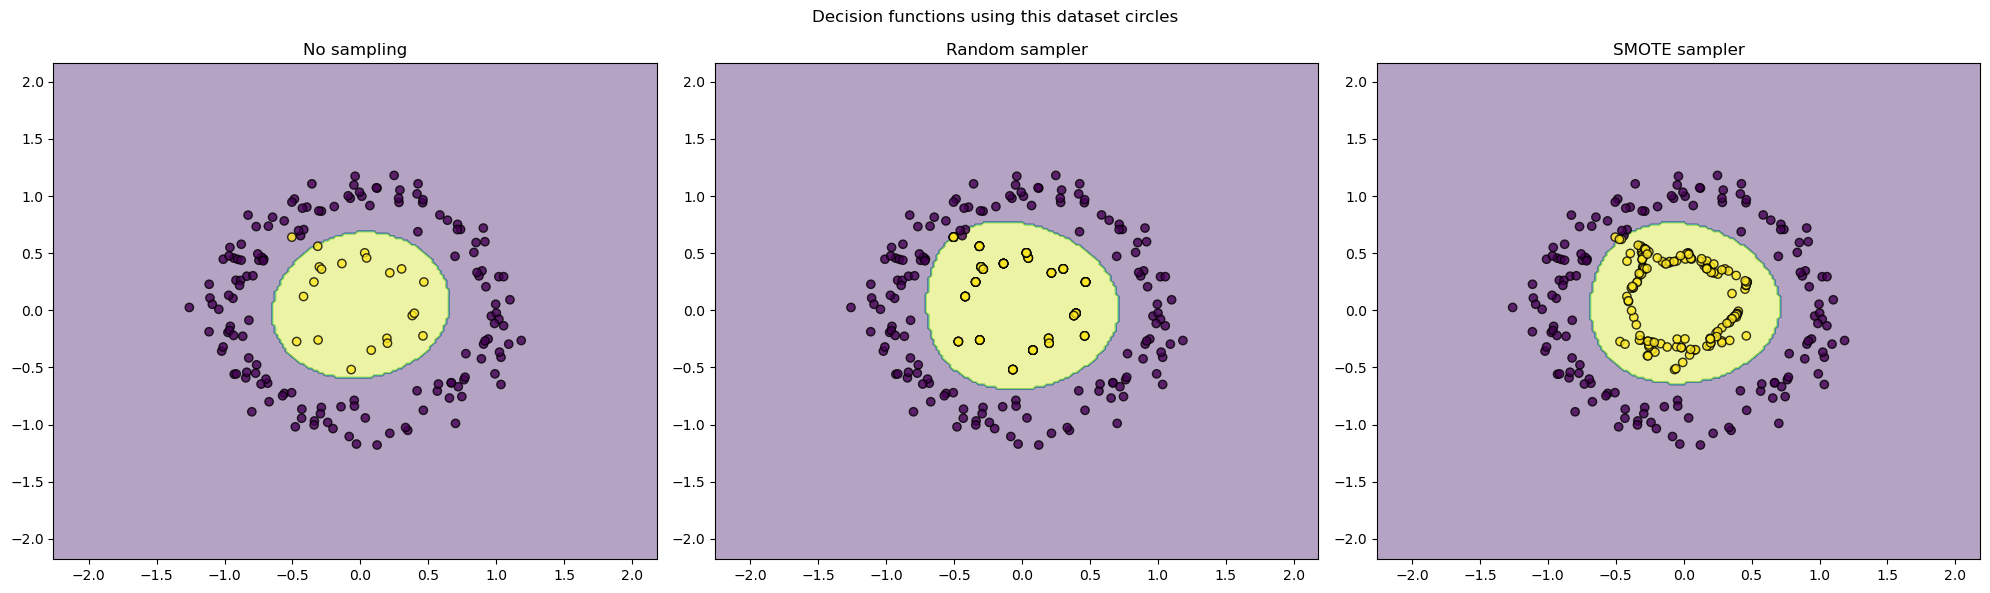

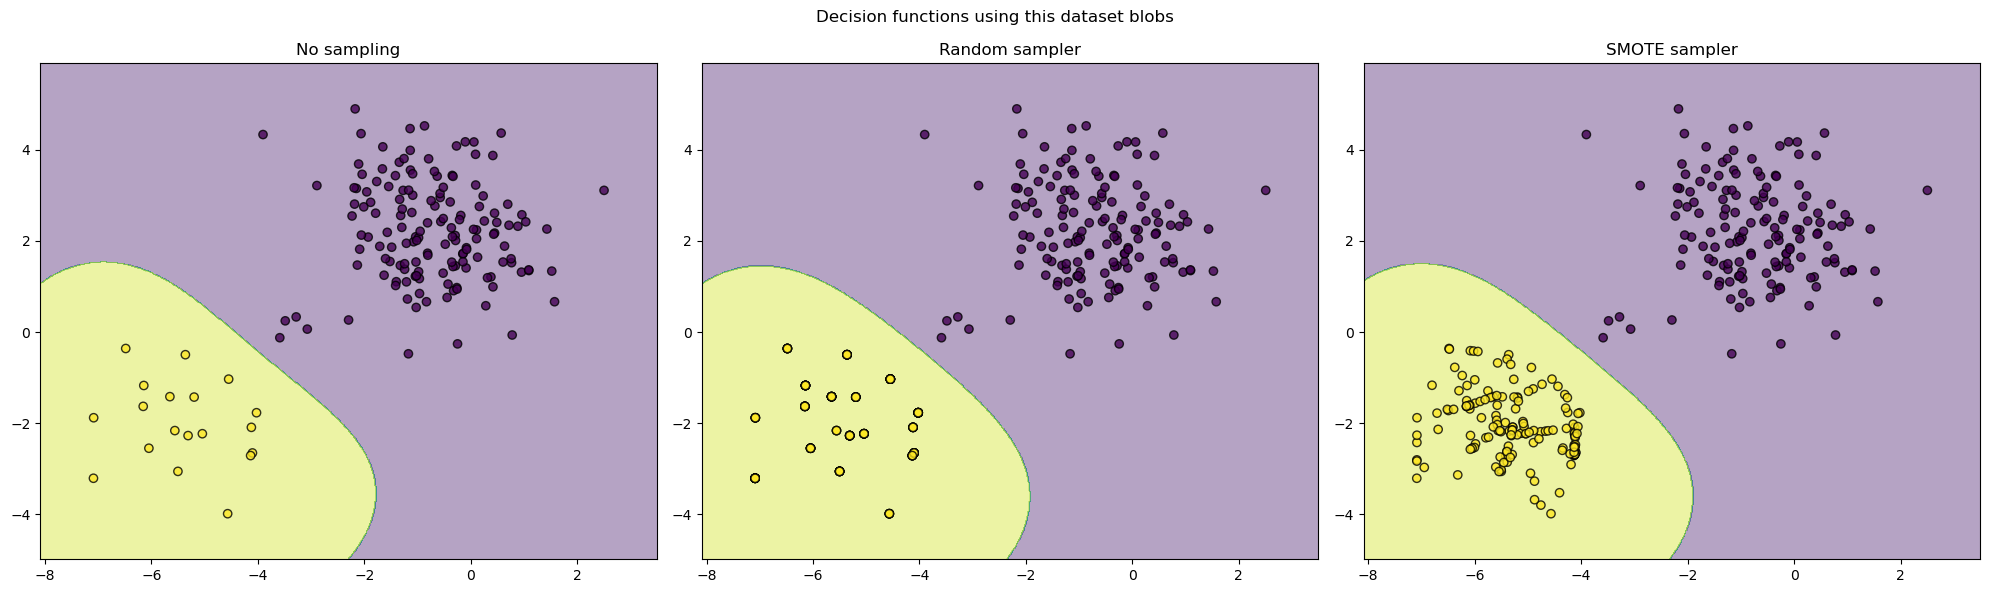

In [8]:
minority_class_imbalance = [2,4,8]

amount_of_samples = 300


models = {
    "No sampling": make_pipeline(StandardScaler(),SVC(gamma='auto')),
    "Random sampler": make_pipeline(StandardScaler(),RandomOverSampler(random_state=42),SVC(gamma='auto')),
    "SMOTE sampler": make_pipeline(StandardScaler(),SMOTE(random_state=42),SVC(gamma='auto')),
}
datasets_scores = {
        2 : {
            "moons" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "circles" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "blobs" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}}
            },
         4 : {
            "moons" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "circles" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "blobs" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}}
            },
         8 : {
            "moons" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "circles" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}},
            "blobs" : {"No sampling" : {"accuracy" : 0, "f1-score" : 0} , "Random sampler" : {"accuracy" : 0, "f1-score" : 0},"SMOTE sampler" : {"accuracy" : 0, "f1-score" : 0}}
            }  
    }
    
for imbalance in minority_class_imbalance:
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("Imbalance rate: ")
    print(imbalance)
    datasets = [
        make_moons(noise=0.2, random_state=0, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)]),
        make_circles(noise=0.1, factor=0.5, random_state=1, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)]),
        make_blobs( random_state=1,  center_box=[-5,5] , cluster_std= 1.1, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)])
    ]
    datasets_name = ["moons", "circles", "blobs"]
    
    
    for ds_cnt, ds in enumerate(datasets):
        print("-------------------------------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------------------------------")
        print("Type of dataset: ")
        print(datasets_name[ds_cnt])
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
        for ax , (title,model) in zip(axs, models.items()):
            
            average_score = 0
            average_f1_score = 0
            print("-------------------------------------------------------------------------------------------------------")
            print("Type of oversampler:")
            print(title)
            for random_state_idx in range(0,10):
                X, y = ds
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.5, random_state=random_state_idx
                )
                model.fit(X_train, y_train)
                
                y_pred =  model.predict(X_test)
                average_score = average_score + accuracy_score(y_pred, y_test)
                average_f1_score = f1_score(y_pred, y_test, pos_label=1) + average_f1_score
                
            if title == "No sampling":
                plot_decision_function(X_train, y_train, model, ax=ax, title=title)
                
            elif title == "Random sampler":
                ros = RandomOverSampler(random_state=42)
                X_res, y_res = ros.fit_resample(X_train, y_train)
                plot_decision_function(X_res, y_res, model, ax=ax, title=title)
                
            elif title == "SMOTE sampler":
                ros = SMOTE(random_state=42)
                X_res, y_res = ros.fit_resample(X_train, y_train)
                plot_decision_function(X_res, y_res, model, ax=ax, title=title)
                
            datasets_scores[imbalance][datasets_name[ds_cnt]][title]["accuracy"] = average_score/10
            datasets_scores[imbalance][datasets_name[ds_cnt]][title]["f1-score"] = average_f1_score/10
            
        fig.suptitle("Decision functions using this dataset " + datasets_name[ds_cnt])
        fig.tight_layout()
                

        
    
print(datasets_scores)    
    



### 1.4.1 Moon dataset results

| Accuracy (Moon dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.964  | 0.963  | 0.968  |
| Class imbalance 1/4   | 0.967  | 0.976  | 0.975  |
| Class imbalance 1/8   | 0.944  | 0.949  | 0.954  |


| f1-score (Moon dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.946  | 0.948  | 0.952  |
| Class imbalance 1/4   | 0.914  | 0.940  | 0.937  |
| Class imbalance 1/8   | 0.721  | 0.794  | 0.813  |

### 1.4.2 Circles dataset results

| Accuracy (Circles dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.993  | 0.992  | 0.994  |
| Class imbalance 1/4   | 0.997  | 0.996  | 0.997  |
| Class imbalance 1/8   | 0.995  | 0.995  | 0.996  |


| f1-score (Circles dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.989  | 0.989  | 0.991  |
| Class imbalance 1/4   | 0.993  | 0.991  | 0.992  |
| Class imbalance 1/8   | 0.979  | 0.977  | 0.983  |

### 1.4.3 Blobs dataset results

| Accuracy (Blobs dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.995  | 0.991  | 0.992  |
| Class imbalance 1/4   | 0.996  | 0.993  | 0.994  |
| Class imbalance 1/8   | 0.996  | 0.990  | 0.995  |


| f1-score (Blobs dataset)   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.992  | 0.987  | 0.989  |
| Class imbalance 1/4   | 0.989  | 0.981  | 0.983  |
| Class imbalance 1/8   | 0.981  | 0.957  | 0.976  |


### 1.4.4 Conclusion results

For both Moon and circle datasets the support vector machine classifier performs better while the blobs dataset consistently performs worse with oversampling. So why is this? 
A mathematical proof would be rigorous and complete although it might be difficult to construct. As a substitute we will look at the data.

The blobs dataset is essentially the only dataset that is linearly seperable, the moon and circles dataset are certainly not linearly seperable so to make them linearly seperable a feature mapping is needed from the RBF-kernel of the Suport Vector Machine. Two conclusions can arrise from this observations:
1. The oversampled data create in the case of the Moon and Circles dataset a better feature mapping that makes it easier to construct a good hyperplane to seperate the data.
2. In the blobs dataset there is no extra data needed to seperate the 2 classes since the unmapped data is already linearly seperable. Creating extra data with SMOTE or random oversampling generates an overfitting on the data.

Furthermore in almost all cases SMOTE oversampling is better than random oversampling. 

So as found in https://www.jair.org/index.php/jair/article/view/10302/24590, there is a benefit from using oversampling to improve the result of the fitting.

## 1.5 Experiment setup for Audio data
https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs?datasetId=2749&sortBy=voteCount

### 1.5.1 Transfer learning model
For this audio classification Densenet is used: 
<center> <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-20_at_11.35.53_PM_KroVKVL.png" ></center>
The paper of densenet can be found at: https://arxiv.org/pdf/1608.06993.pdf
A little notice will be layed on the type of layers and their usage.

#### 1.5.1.1 Convolution layer
A convolutional layer in essence exists of 3 things:
- An input vector (The image) for example of dimensions (128,128,3)
- A filter (feature detector) that will extract features from an image.
- An output matrix that functions as feature map.
<center> <img src="https://www.researchgate.net/profile/Hiromu-Yakura/publication/323792694/figure/fig1/AS:615019968475136@1523643595196/Outline-of-the-convolutional-layer.png" ></center>

#### 1.5.1.2 Dense layer
A dense layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer.
<center> <img src="https://www.researchgate.net/profile/Hadley-Brooks/publication/270274130/figure/fig3/AS:667886670594050@1536247999230/Architecture-of-a-multilayer-neural-network-with-one-hidden-layer-The-input-layer.png" ></center>

#### 1.5.1.3 Dense block
A Dense Block is a module used in convolutional neural networks that connects all layers (with matching feature-map sizes) directly with each other.
Note that these are the outputs of convolutional layers as explained in 1.5.1.1
<center> <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-20_at_11.33.17_PM_Mt0HOZL.png" ></center>

#### 1.5.1.4 Pooling layer
A pooling layer will reduce the dimensions of a hidden layer by clustering the previous layer to a new layer that has a lower dimensionality.
In max pooling the maximum value of a cluster will be taken during average pooling the average value of a cluster will be taken, an overview of this can be seen in the image below.
<center> <img src="https://www.researchgate.net/publication/340812216/figure/fig4/AS:928590380138496@1598404607456/Pooling-layer-operation-oproaches-1-Pooling-layers-For-the-function-of-decreasing-the.png" ></center>



In [4]:
import tensorflow as tf

pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(128,128,3),
                            include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.save_weights('model.h5')

### 1.5.2 t-SNE visualization

Because of the high-dimensionality of the data it is not possible to plot the decision boundouries as done in the lower dimensional data. To overcome this difficulty t-SNE is used in combination with the node weights of the last layer before classifcation.
So visually the last non output layer will be chosen sas input for the t-SNE visualization. 
<center> <img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/01/embedding_layer.png" ></center>
The way of working is based on following paper:

https://arxiv.org/pdf/2107.12547.pdf





In [5]:
def TSNE_visualization(model, testX, title):


    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = model2(testX)
    features = np.nan_to_num(features)
    labels = np.argmax(model(testX), axis=-1)
    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):

        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range
    print("The Labels")
    print(labels)
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue']
    classes = ["dog" , "cat"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()

### 1.5.3 Audio augmentation
For the audio augmentation a library called audiomentations is used:

https://zenodo.org/record/7885479

The parameters to augment the audio are:

- Adding of GaussianNoise
- Time stretch of the audio
- Pitch Shift of the audio
- Shift of the audio (Cut some of the audio)

The image sent to the neural network is a melspectogram as seen in the image below: 
<center> <img src="https://librosa.org/doc/main/_images/librosa-feature-melspectrogram-1.png" ></center>

The Y-axis denotes the frequency of the noise while the X-axis is used to determine it's point in time, color is used to determine the amplitude of the noise.



For demonstration purposes, some augmentations are listed below.

In [23]:
train_dir = 'catvsdog/cats_dogs/train'
test_dir = 'catvsdog/cats_dogs/test'
train_paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        train_paths+=[(os.path.join(dirname, filename))]
test_paths=[]
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        test_paths+=[(os.path.join(dirname, filename))]
        
Name=['dog','cat']
N=list(range(len(Name)))    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))
Wrong_Name=['test','cats']
fix_mapping=dict(zip(Wrong_Name,Name))

https://www.kaggle.com/code/tanulsingh077/audio-albumentations-transform-your-audio#Adding-Noise




In [24]:
class AudioTransform(BasicTransform):
    """ Transform for audio task. This is the main class where we override the targets and update params function for our need"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

#### 1.5.3.1 Gaussian noise

In [28]:
class AddGaussianNoisee(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False, p=0.5):
        super(AddGaussianNoisee, self).__init__(always_apply, p)
        
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        ''' 
        noise = np.random.randn(len(data))
        data_wn = data + 0.005*noise
        return data_wn
    


In [29]:
audio_path = 'catvsdog/cats_dogs/cat_1.wav'

y,sr = librosa.load(audio_path,sr=22050)

print('Audio Intially')
ipd.Audio(y, rate=sr)

Audio Intially


In [30]:
transform = AddGaussianNoisee(p=1.0)

print('audio after transform')
ipd.Audio(transform(data=y)['data'],rate=sr)

audio after transform


#### 1.5.3.2 Pitch shift

In [31]:
class PitchShift(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False, p=0.5 , n_steps=None):
        super(PitchShift, self).__init__(always_apply, p)
        '''
        nsteps here is equal to number of semitones
        '''
        
        self.n_steps = n_steps
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        return librosa.effects.pitch_shift(data,sr=22050,n_steps=self.n_steps)

In [32]:
audio_path = 'catvsdog/cats_dogs/cat_1.wav'

y,sr = librosa.load(audio_path,sr=22050)

print('Audio Intially')
ipd.Audio(y, rate=sr)

Audio Intially


In [33]:
transform = PitchShift(p=1.0,n_steps=4)

print('audio after transform')
ipd.Audio(transform(data=y)['data'],rate=sr)

audio after transform


### 1.5.4 Experiment setup for validation

The experiment again has a simular approach, the experiment will be run 3 times each with a different rate of inbalance.

In [37]:
def retrieve_data_train(train_paths, train, train_labels,dog_amount):
    
    amount_of_dogs = 0 
    imbalance = 0
    
    for path in train_paths:
        label=path.split('\\')[-2]
        if label == "dog":
            imbalance = imbalance - 1
            amount_of_dogs = amount_of_dogs +1
        elif label == "cat":
            imbalance = imbalance + 1
        if amount_of_dogs > dog_amount:
            break
        y, sr = librosa.load(path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        img=log_mel_spectrogram
        img=cv2.resize(np.array(img),dsize=(128,128))
        X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        train+=[X*255]
        train_labels+=[normal_mapping[label]]
    return train , train_labels , imbalance

def retrieve_data_train_augment(train_paths, train, train_labels,dog_amount):
    amount_of_dogs = 0 
    imbalance = 0
    
    augment = Compose([
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.01, p=0.5),
        TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
        Shift(min_fraction=-0.25, max_fraction=0.25, p=0.5),
    ])
    
    # data augmentation
    while imbalance != 0:
        for path in train_paths:
            label=path.split('\\')[-2]
            if imbalance == 0:
                break
            elif label == "dog":
                y, sr = librosa.load(path)
                y = augment(samples=y, sample_rate=sr)
                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                img=log_mel_spectrogram
                img=cv2.resize(np.array(img),dsize=(128,128))
                X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
                train+=[X*255]
                train_labels+=[normal_mapping[label]]
                imbalance = imbalance - 1
    return train , train_labels , imbalance



def retrieve_data_test(test_paths, test, test_labels):
    for path in test_paths:
        label=path.split('\\')[-2]
        y, sr = librosa.load(path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        img=log_mel_spectrogram
        img=cv2.resize(np.array(img),dsize=(128,128))
        X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        test+=[X*255]
        test_labels+=[normal_mapping[fix_mapping[label]]]
        
    return test , test_labels

def report_data(testX,test_labels,experiment_basis,model):
    y_pred = model.predict(testX)
    y_pred2 = np.argmax(y_pred,axis=1)
    ground = np.argmax(test_labels,axis=1)
    print(classification_report(ground,y_pred2,target_names=Name,digits=4))
    cm = confusion_matrix(ground, y_pred2, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["dog" , "cat"]).plot()
    disp.ax_.set_title(experiment_basis)
    
    
    

Epoch 1/50
7/7 [==============================] - 16s 1s/step - loss: 5.3421 - accuracy: 0.5524 - val_loss: 1.7029 - val_accuracy: 0.5522
Epoch 2/50
7/7 [==============================] - 3s 516ms/step - loss: 1.0047 - accuracy: 0.7667 - val_loss: 0.6608 - val_accuracy: 0.8806
Epoch 3/50
7/7 [==============================] - 3s 480ms/step - loss: 0.5702 - accuracy: 0.8667 - val_loss: 0.5992 - val_accuracy: 0.7910
Epoch 4/50
7/7 [==============================] - 3s 495ms/step - loss: 0.3148 - accuracy: 0.9238 - val_loss: 0.7387 - val_accuracy: 0.8955
Epoch 5/50
7/7 [==============================] - 4s 541ms/step - loss: 0.2888 - accuracy: 0.9238 - val_loss: 0.5419 - val_accuracy: 0.8507
Epoch 6/50
7/7 [==============================] - 4s 529ms/step - loss: 0.1027 - accuracy: 0.9667 - val_loss: 0.5660 - val_accuracy: 0.9104
Epoch 7/50
7/7 [==============================] - 3s 507ms/step - loss: 0.0874 - accuracy: 0.9619 - val_loss: 0.4821 - val_accuracy: 0.8657
Epoch 8/50
7/7 [======

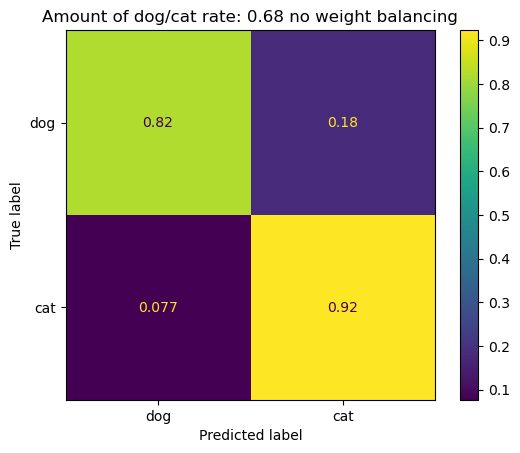

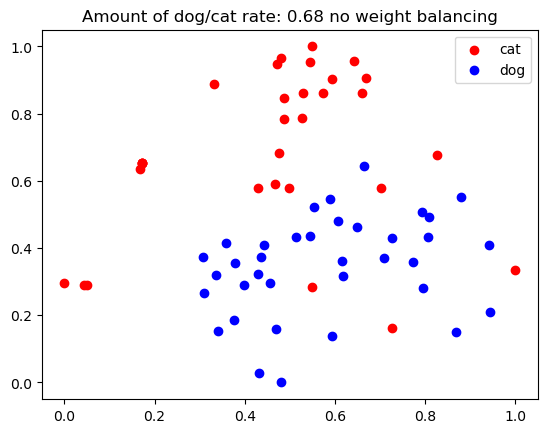

Epoch 1/50
7/7 [==============================] - 11s 852ms/step - loss: 2.5518 - accuracy: 0.6190 - val_loss: 1.0711 - val_accuracy: 0.7612
Epoch 2/50
7/7 [==============================] - 3s 498ms/step - loss: 1.2098 - accuracy: 0.7762 - val_loss: 0.7538 - val_accuracy: 0.8955
Epoch 3/50
7/7 [==============================] - 3s 493ms/step - loss: 0.5498 - accuracy: 0.8524 - val_loss: 0.5293 - val_accuracy: 0.8955
Epoch 4/50
7/7 [==============================] - 3s 478ms/step - loss: 0.1963 - accuracy: 0.9333 - val_loss: 0.6049 - val_accuracy: 0.8806
Epoch 5/50
7/7 [==============================] - 3s 455ms/step - loss: 0.1042 - accuracy: 0.9667 - val_loss: 0.6156 - val_accuracy: 0.8955
Epoch 6/50
7/7 [==============================] - 3s 439ms/step - loss: 0.0461 - accuracy: 0.9810 - val_loss: 0.6060 - val_accuracy: 0.8806
Epoch 7/50
7/7 [==============================] - 3s 488ms/step - loss: 0.0330 - accuracy: 0.9857 - val_loss: 0.6572 - val_accuracy: 0.8806
Epoch 8/50
7/7 [===

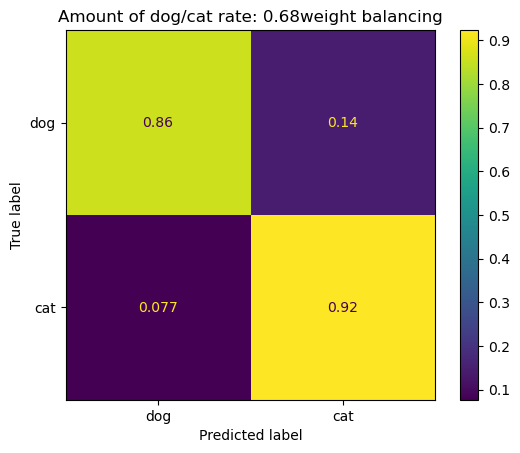

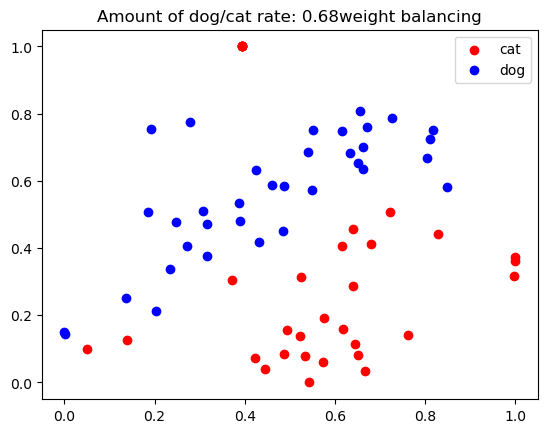

Epoch 1/50
7/7 [==============================] - 11s 1s/step - loss: 4.4483 - accuracy: 0.5762 - val_loss: 0.9169 - val_accuracy: 0.8507
Epoch 2/50
7/7 [==============================] - 3s 491ms/step - loss: 1.1188 - accuracy: 0.7952 - val_loss: 0.6065 - val_accuracy: 0.8806
Epoch 3/50
7/7 [==============================] - 3s 466ms/step - loss: 0.3254 - accuracy: 0.8857 - val_loss: 0.7321 - val_accuracy: 0.8657
Epoch 4/50
7/7 [==============================] - 3s 462ms/step - loss: 0.2315 - accuracy: 0.9190 - val_loss: 0.6954 - val_accuracy: 0.8955
Epoch 5/50
7/7 [==============================] - 3s 455ms/step - loss: 0.0844 - accuracy: 0.9667 - val_loss: 0.6269 - val_accuracy: 0.8209
Epoch 6/50
7/7 [==============================] - 3s 507ms/step - loss: 0.0681 - accuracy: 0.9762 - val_loss: 0.6663 - val_accuracy: 0.8806
Epoch 7/50
7/7 [==============================] - 3s 497ms/step - loss: 0.0416 - accuracy: 0.9810 - val_loss: 0.6462 - val_accuracy: 0.8657
Epoch 8/50
7/7 [======

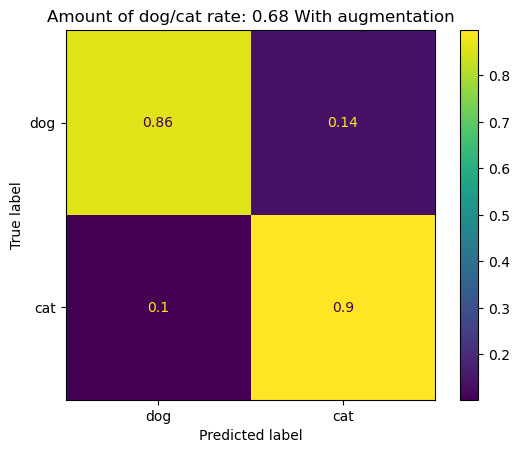

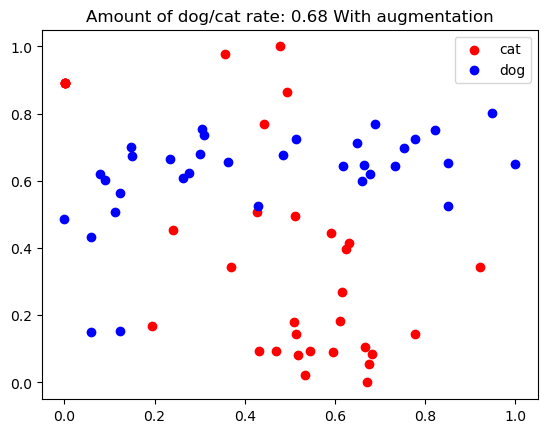

Epoch 1/50
6/6 [==============================] - 11s 979ms/step - loss: 4.2936 - accuracy: 0.6596 - val_loss: 2.7609 - val_accuracy: 0.5672
Epoch 2/50
6/6 [==============================] - 3s 488ms/step - loss: 1.4878 - accuracy: 0.7926 - val_loss: 0.5935 - val_accuracy: 0.8955
Epoch 3/50
6/6 [==============================] - 3s 526ms/step - loss: 0.5764 - accuracy: 0.8670 - val_loss: 0.4595 - val_accuracy: 0.8806
Epoch 4/50
6/6 [==============================] - 3s 521ms/step - loss: 0.2166 - accuracy: 0.9415 - val_loss: 0.3500 - val_accuracy: 0.8806
Epoch 5/50
6/6 [==============================] - 3s 483ms/step - loss: 0.1339 - accuracy: 0.9468 - val_loss: 0.4483 - val_accuracy: 0.8955
Epoch 6/50
6/6 [==============================] - 3s 493ms/step - loss: 0.0968 - accuracy: 0.9468 - val_loss: 0.3891 - val_accuracy: 0.8657
Epoch 7/50
6/6 [==============================] - 3s 473ms/step - loss: 0.0720 - accuracy: 0.9734 - val_loss: 0.4215 - val_accuracy: 0.8657
Epoch 8/50
6/6 [===

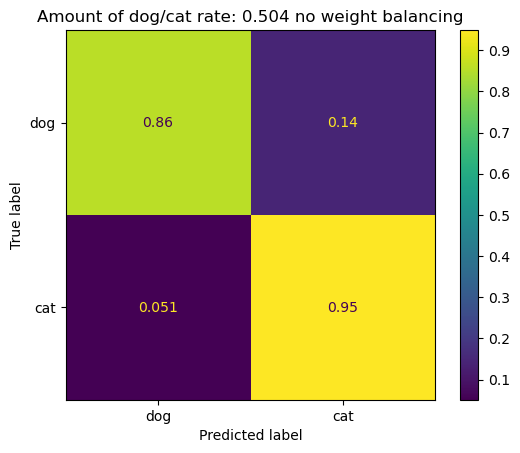

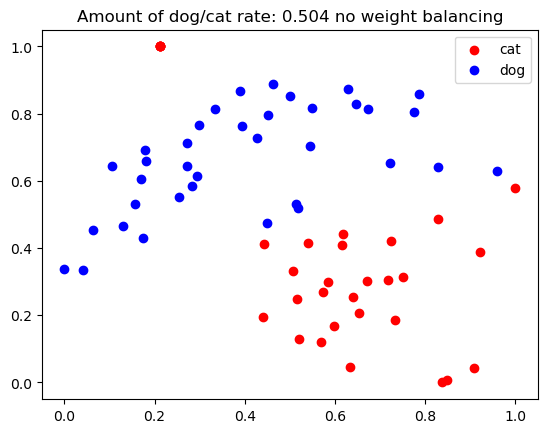

Epoch 1/50
6/6 [==============================] - 13s 1s/step - loss: 2.2537 - accuracy: 0.5106 - val_loss: 0.7675 - val_accuracy: 0.8060
Epoch 2/50
6/6 [==============================] - 3s 543ms/step - loss: 0.7757 - accuracy: 0.8511 - val_loss: 1.4453 - val_accuracy: 0.7612
Epoch 3/50
6/6 [==============================] - 3s 538ms/step - loss: 0.3939 - accuracy: 0.8936 - val_loss: 1.7515 - val_accuracy: 0.6866
Epoch 4/50
6/6 [==============================] - 3s 546ms/step - loss: 0.3311 - accuracy: 0.8404 - val_loss: 1.4393 - val_accuracy: 0.8806
Epoch 5/50
6/6 [==============================] - 3s 550ms/step - loss: 0.2410 - accuracy: 0.9309 - val_loss: 2.1074 - val_accuracy: 0.7313
Epoch 6/50
6/6 [==============================] - 3s 563ms/step - loss: 0.1718 - accuracy: 0.9096 - val_loss: 1.2228 - val_accuracy: 0.8955
Epoch 7/50
6/6 [==============================] - 3s 543ms/step - loss: 0.2937 - accuracy: 0.9362 - val_loss: 1.5288 - val_accuracy: 0.7612
Epoch 8/50
6/6 [======

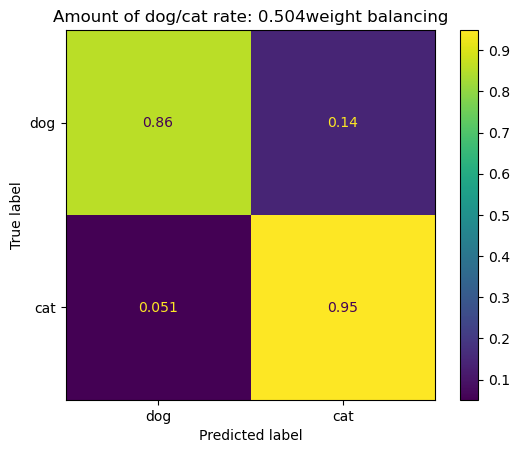

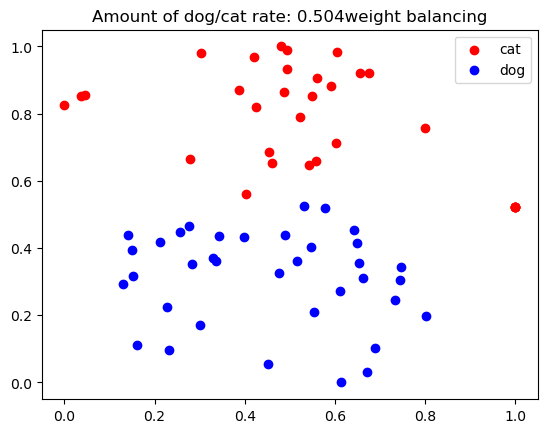

Epoch 1/50
6/6 [==============================] - 11s 972ms/step - loss: 3.2610 - accuracy: 0.6543 - val_loss: 1.2552 - val_accuracy: 0.7612
Epoch 2/50
6/6 [==============================] - 3s 541ms/step - loss: 1.2448 - accuracy: 0.8032 - val_loss: 0.8520 - val_accuracy: 0.8358
Epoch 3/50
6/6 [==============================] - 3s 528ms/step - loss: 0.6394 - accuracy: 0.8298 - val_loss: 0.9655 - val_accuracy: 0.8657
Epoch 4/50
6/6 [==============================] - 3s 517ms/step - loss: 0.8368 - accuracy: 0.8617 - val_loss: 0.7169 - val_accuracy: 0.8209
Epoch 5/50
6/6 [==============================] - 3s 476ms/step - loss: 0.3668 - accuracy: 0.8670 - val_loss: 0.8287 - val_accuracy: 0.8955
Epoch 6/50
6/6 [==============================] - 3s 472ms/step - loss: 0.2795 - accuracy: 0.9255 - val_loss: 0.5554 - val_accuracy: 0.8955
Epoch 7/50
6/6 [==============================] - 3s 513ms/step - loss: 0.1327 - accuracy: 0.9415 - val_loss: 0.5802 - val_accuracy: 0.8806
Epoch 8/50
6/6 [===

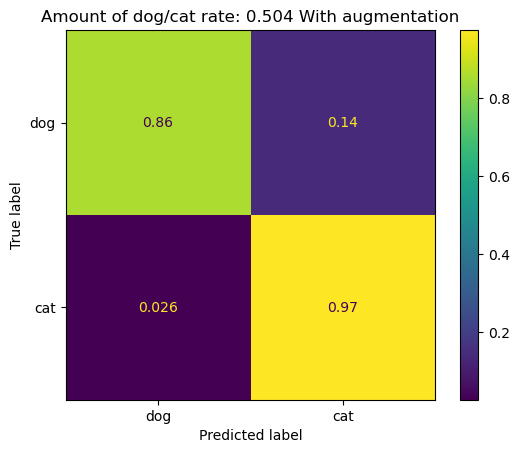

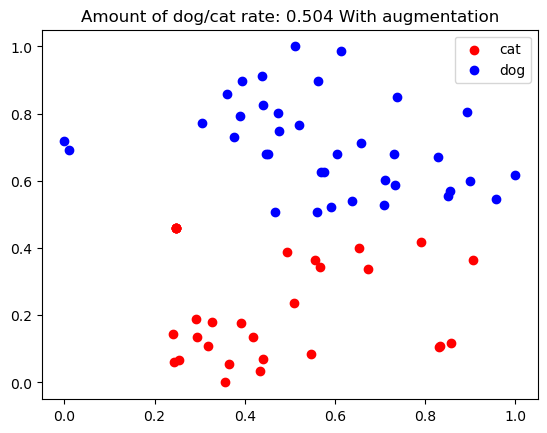

Epoch 1/50
5/5 [==============================] - 11s 1s/step - loss: 7.4703 - accuracy: 0.6968 - val_loss: 10.2988 - val_accuracy: 0.5821
Epoch 2/50
5/5 [==============================] - 2s 491ms/step - loss: 2.1983 - accuracy: 0.7419 - val_loss: 1.2912 - val_accuracy: 0.5970
Epoch 3/50
5/5 [==============================] - 2s 491ms/step - loss: 0.6662 - accuracy: 0.8258 - val_loss: 3.6679 - val_accuracy: 0.6567
Epoch 4/50
5/5 [==============================] - 2s 491ms/step - loss: 0.3320 - accuracy: 0.8903 - val_loss: 2.1778 - val_accuracy: 0.7015
Epoch 5/50
5/5 [==============================] - 2s 522ms/step - loss: 0.3022 - accuracy: 0.9032 - val_loss: 2.8571 - val_accuracy: 0.6866
Epoch 6/50
5/5 [==============================] - 3s 567ms/step - loss: 0.1473 - accuracy: 0.9484 - val_loss: 2.4409 - val_accuracy: 0.7015
Epoch 7/50
5/5 [==============================] - 3s 548ms/step - loss: 0.0919 - accuracy: 0.9548 - val_loss: 1.7049 - val_accuracy: 0.7015
Epoch 8/50
5/5 [=====

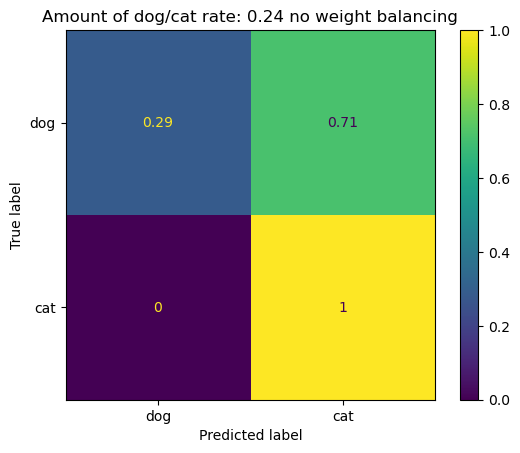

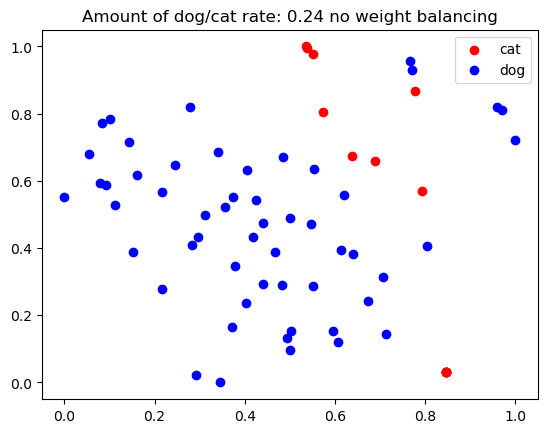

Epoch 1/50
5/5 [==============================] - 10s 1s/step - loss: 2.9874 - accuracy: 0.3290 - val_loss: 15.2584 - val_accuracy: 0.4179
Epoch 2/50
5/5 [==============================] - 2s 505ms/step - loss: 2.6747 - accuracy: 0.4645 - val_loss: 1.6291 - val_accuracy: 0.7463
Epoch 3/50
5/5 [==============================] - 2s 504ms/step - loss: 1.0919 - accuracy: 0.6774 - val_loss: 1.9402 - val_accuracy: 0.6567
Epoch 4/50
5/5 [==============================] - 2s 530ms/step - loss: 0.3786 - accuracy: 0.7871 - val_loss: 2.1670 - val_accuracy: 0.7015
Epoch 5/50
5/5 [==============================] - 3s 551ms/step - loss: 0.1571 - accuracy: 0.9226 - val_loss: 2.3141 - val_accuracy: 0.6866
Epoch 6/50
5/5 [==============================] - 3s 571ms/step - loss: 0.1585 - accuracy: 0.8903 - val_loss: 1.5198 - val_accuracy: 0.6866
Epoch 7/50
5/5 [==============================] - 3s 550ms/step - loss: 0.0835 - accuracy: 0.9355 - val_loss: 2.4782 - val_accuracy: 0.7164
Epoch 8/50
5/5 [=====

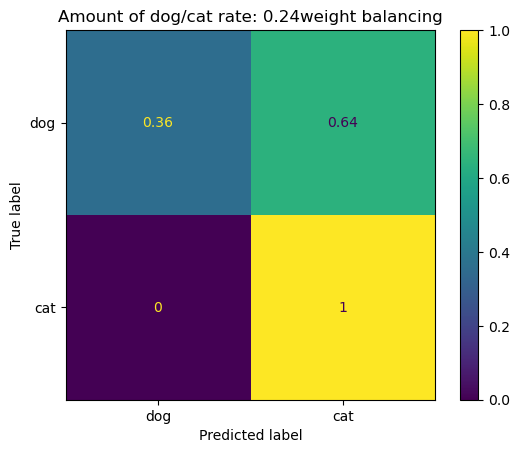

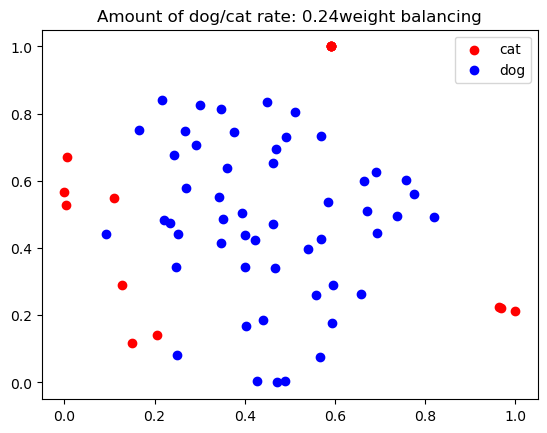

Epoch 1/50
5/5 [==============================] - 10s 1s/step - loss: 7.2139 - accuracy: 0.6839 - val_loss: 11.2097 - val_accuracy: 0.5821
Epoch 2/50
5/5 [==============================] - 2s 504ms/step - loss: 2.3697 - accuracy: 0.7355 - val_loss: 1.0841 - val_accuracy: 0.6567
Epoch 3/50
5/5 [==============================] - 2s 514ms/step - loss: 0.5609 - accuracy: 0.8323 - val_loss: 1.9763 - val_accuracy: 0.6567
Epoch 4/50
5/5 [==============================] - 3s 578ms/step - loss: 0.3803 - accuracy: 0.8516 - val_loss: 0.6908 - val_accuracy: 0.6716
Epoch 5/50
5/5 [==============================] - 3s 560ms/step - loss: 0.2304 - accuracy: 0.8839 - val_loss: 0.9821 - val_accuracy: 0.6866
Epoch 6/50
5/5 [==============================] - 3s 556ms/step - loss: 0.1890 - accuracy: 0.9032 - val_loss: 0.8476 - val_accuracy: 0.7015
Epoch 7/50
5/5 [==============================] - 2s 510ms/step - loss: 0.1135 - accuracy: 0.9548 - val_loss: 0.5521 - val_accuracy: 0.7313
Epoch 8/50
5/5 [=====

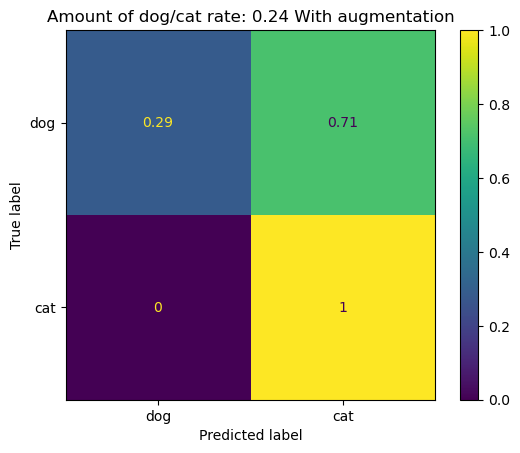

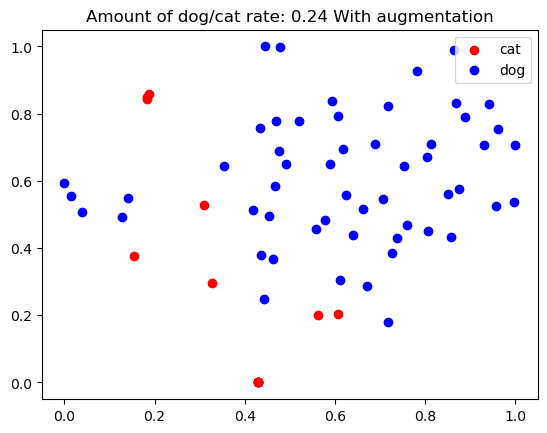

In [39]:
Amount_of_dogs = [85,63,30]
EPOCHS=50

pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(128,128,3),
                            include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.save_weights('model.h5')

for dog_amount in Amount_of_dogs:
    experiment_string = ''
    experiment_string = experiment_string + "Amount of dog/cat rate: " + str(dog_amount/125)
    
    train=[]
    train_labels=[]
    imbalance = 0
    #Data gathering train
    train , train_labels , imbalance = retrieve_data_train(train_paths, train, train_labels, dog_amount)
    
    test=[]
    test_labels=[]
    #data gathering test
    test , test_labels  = retrieve_data_test(test_paths, test, test_labels)
    
    trainX_no_augment = np.array(train)
    testX_no_augment = np.array(test)
    train_labels_no_augment = np.array(train_labels)
    test_labels_no_augment = np.array(test_labels)
    train_labels_no_augment = to_categorical(train_labels)
    test_labels_no_augment = to_categorical(test_labels)
    
    experiment_basis = experiment_string + " no weight balancing"
    model.load_weights('model.h5')

    his=model.fit(x= trainX_no_augment, y = train_labels_no_augment,
                  validation_data=(testX_no_augment,test_labels_no_augment),epochs=EPOCHS)
    model.save('modelentire.h5')
    model = load_model("modelentire.h5")
    report_data(testX_no_augment,test_labels_no_augment,experiment_basis,model)
    
    TSNE_visualization(model, testX_no_augment, experiment_basis)
    model.load_weights('model.h5')
    #########################################################################################################################
    ######################################            Weight balacing          ##############################################
    #########################################################################################################################
    experiment_weight = experiment_string + "weight balancing"
    his=model.fit(x= trainX_no_augment, y = train_labels_no_augment,
                  validation_data=(testX_no_augment,test_labels_no_augment),epochs=EPOCHS,  class_weight= { 0 : 125/dog_amount , 1 : dog_amount/125 })
    model.save('modelentire.h5')
    model = load_model("modelentire.h5")
    report_data(testX_no_augment,test_labels_no_augment,experiment_weight,model)
    TSNE_visualization(model, testX_no_augment , experiment_weight)
    model.load_weights('model.h5')
    
    #########################################################################################################################
    ######################################            Augmentations            ##############################################
    #########################################################################################################################
    retrieve_data_train_augment(train_paths, train, train_labels,dog_amount)
    
    trainX = np.array(train)
    testX = np.array(test)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    count_dog = 0
    count_cat = 0

    for label in train_labels:
        if label[1] == 1:
            count_cat = count_cat + 1
        elif label[1] == 0:
            count_dog = count_dog + 1
            
            
    experiment_aug = experiment_string + " With augmentation"
    model.load_weights('model.h5')
    his=model.fit(x= trainX, y = train_labels,
                  validation_data=(testX,test_labels),epochs=EPOCHS)
    model.save('modelentire.h5')
    model = load_model("modelentire.h5" )
    report_data(testX,test_labels,experiment_aug,model)
    TSNE_visualization(model, testX, experiment_aug)
    model.load_weights('model.h5')


### 1.5.5 Conclusion results

#### 1.5.5.1 quantitative results

| Accuracy  | no augmentations  | weight rebalancing  | Augmentations rebalancing  |
|---|---|---|---|
| Class imbalance 2/3  | 0.88  | 0.90  | 0.88  |
| Class imbalance 1/2   | 0.91  | 0.91  | 0.93  |
| Class imbalance 1/4   | 0.70  | 0.73  | 0.70  |


| f1-score (minority class) | no augmentations  | weight rebalancing  | Augmentations rebalancing  |
|---|---|---|---|
| Class imbalance 2/3  | 0.85  | 0.87  | 0.86  |
| Class imbalance 1/4   | 0.89  | 0.89  | 0.91  |
| Class imbalance 1/8   | 0.44  | 0.52  | 0.44  |


Looking at the results it can be seen that weight rebalncing is in all cases the better option over doing nothing to the imbalance at all. Augmentations in some cases give a better result but not in all cases. What could be the cause of this? Two factors are important in this case, is the model to optimized for image classification and are audio to image generators not optimized for this. Are the augmentations in some cases too strong and create an undecidable noise.
In conclusion augmented audio don't enhance the model and further research could be done in following questions:
- Can models be optimized for audio to image inputs?
- Are augmentations clear enough for professional anotators?

#### 1.5.5.2 Visual results
For the Confusion matrix and the t-SNE plot simular results are generated for the 2/3th and 1/2th imbalance, the imbalance of 1/4th has strictly different results.

##### 1.5.5.2.1 Confusion matrix
The confusion matrix clearly shows there is a misclassification from the minority class to the majority class. This is a weak misclassification in case of the 2/3th and 1/2th imbalance. In case of the 1/4th imbalance more samples are labeled wrong than right.

##### 1.5.5.2.2 t-SNE plot
The t-SNE plot shows a clear seperation of samples in cases of the low imbalance cases of 2/3th and 1/2th, the seperation between classes fades away for the imbalance of 1/4th.

## 1.6 Experiment setup for image data

The experiment has the same structure of 1.5, instead of audio, images are used from [this](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification) dataset.

In [99]:
def report_data_image(y_pred,y_true,experiment_string):
    print(classification_report(y_pred,y_true,digits=4))
    cm = confusion_matrix(y_pred,y_true, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Chihuaha" , "Cookie"]).plot()
    disp.ax_.set_title(experiment_string)
    
    
def get_predictions_and_true_label(test_set, model, y_true,y_pred):
    # iterate over the dataset
    for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
        # append true labels
        y_true.append(label_batch.numpy().tolist())
        # compute predictions
        preds = model.predict(image_batch)

        # append predicted labels
        for prediction in preds:
            if prediction[0] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
    y_true = [item for sublist in y_true for item in sublist]
    
    return y_true, y_pred
    
    
    

def shrink_vector(vector, max_val):
    replacement = []
    for i in vector:
        if i > max_val:
            break
        else:
            replacement.append(i)
    return replacement
    

In [100]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### 1.6.1 Sequential deep learning model

In [101]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2

model = Sequential([
    InputLayer(input_shape = (64,64,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')

])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.save_weights("modelimage.h5")

In [102]:
def TSNE_visualization_image(model, testX, title):
    

    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    y_pred = []
    for p, _ in testX.take(1): # Takes 1 batch
        features = model2(p)         # Predict 1 batch
        preds = model.predict(p)

        for prediction in preds:
            if prediction[0] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
    
    labels = y_pred

    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):

        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range

    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue']
    classes = ["Chihuaha" , "Cookie"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        indices = shrink_vector(indices, len(tx) - 1)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chihuahua', 'muffin']
[2559, 2174]
Epoch 1/50
10/10 [==============================] - 19s 2s/step - loss: 1.0572 - accuracy: 0.6453 - val_loss: 3.3386 - val_accuracy: 0.5405
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.3952 - accuracy: 0.8350 - val_loss: 2.9871 - val_accuracy: 0.5405
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 0.3144 - accuracy: 0.8772 - val_loss: 6.9333 - val_accuracy: 0.5405
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 0.2837 - accuracy: 0.8899 - val_loss: 3.3578 - val_accuracy: 0.5405
Epoch 5/50
10/10 [==============================] - 18s 2s/step - loss: 0.2345 - accuracy: 0.9077 - val_loss: 4.1255 - val_accuracy: 0.5405
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.2013 - accuracy: 0.9195 - val_loss: 1.7690 - val_accuracy: 0.5405
Epoch 7/50
10/10 [=======================

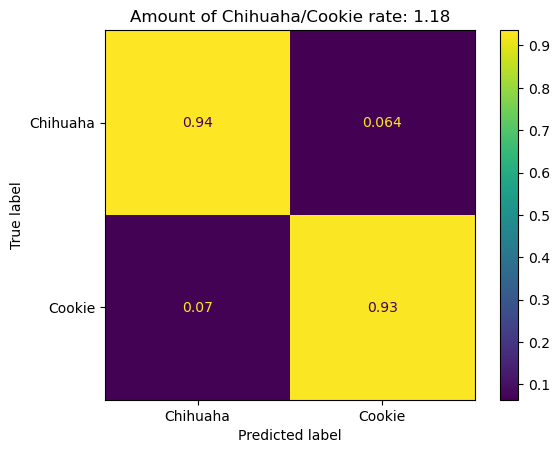

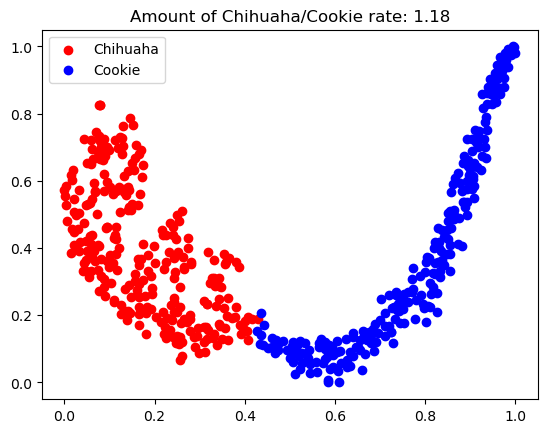

Found 3398 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1224, 2174]
Epoch 1/50
7/7 [==============================] - 14s 2s/step - loss: 1.9632 - accuracy: 0.5530 - val_loss: 8.2548 - val_accuracy: 0.4595
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.5122 - accuracy: 0.7702 - val_loss: 5.0113 - val_accuracy: 0.5405
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 0.4070 - accuracy: 0.8302 - val_loss: 14.0018 - val_accuracy: 0.5405
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 0.3349 - accuracy: 0.8652 - val_loss: 1.3370 - val_accuracy: 0.5752
Epoch 5/50
7/7 [==============================] - 13s 2s/step - loss: 0.2920 - accuracy: 0.8793 - val_loss: 2.7301 - val_accuracy: 0.5405
Epoch 6/50
7/7 [==============================] - 13s 2s/step - loss: 0.2520 - accuracy: 0.8999 - val_loss: 3.8126 - val_accuracy: 0.5405
Epoch 7/50
7/7 [==============================] - 13

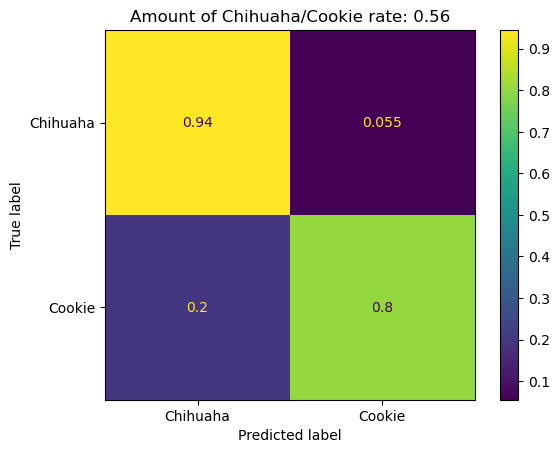

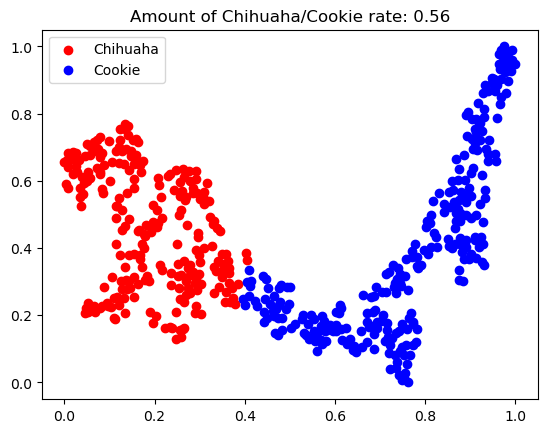

Weight balancing 1/2
Epoch 1/50
7/7 [==============================] - 14s 2s/step - loss: 0.9482 - accuracy: 0.5486 - val_loss: 5.1784 - val_accuracy: 0.5405
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.3298 - accuracy: 0.7681 - val_loss: 4.9155 - val_accuracy: 0.5405
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 0.2523 - accuracy: 0.8634 - val_loss: 2.7005 - val_accuracy: 0.5405
Epoch 4/50
7/7 [==============================] - 12s 2s/step - loss: 0.2134 - accuracy: 0.8811 - val_loss: 1.4843 - val_accuracy: 0.5405
Epoch 5/50
7/7 [==============================] - 12s 2s/step - loss: 0.1845 - accuracy: 0.8999 - val_loss: 4.0517 - val_accuracy: 0.5405
Epoch 6/50
7/7 [==============================] - 12s 2s/step - loss: 0.1608 - accuracy: 0.9111 - val_loss: 1.4666 - val_accuracy: 0.5405
Epoch 7/50
7/7 [==============================] - 12s 2s/step - loss: 0.1395 - accuracy: 0.9208 - val_loss: 1.0537 - val_accuracy: 0.5414
Epoch 8/50
7/

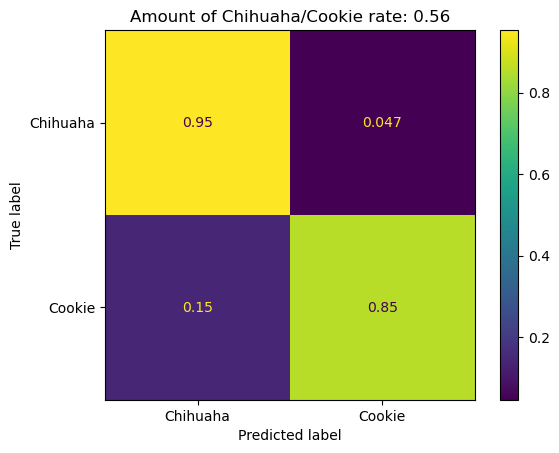

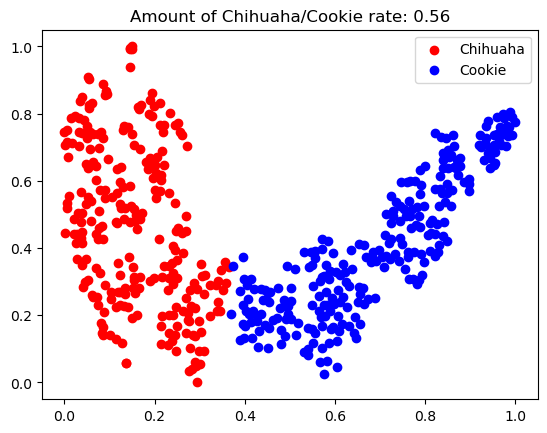

Found 2694 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chihuaha', 'muffin']
[520, 2174]
Epoch 1/50
6/6 [==============================] - 11s 2s/step - loss: 1.7922 - accuracy: 0.5835 - val_loss: 8.7197 - val_accuracy: 0.5405
Epoch 2/50
6/6 [==============================] - 10s 2s/step - loss: 0.4574 - accuracy: 0.8181 - val_loss: 3.8066 - val_accuracy: 0.4595
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 0.3294 - accuracy: 0.8623 - val_loss: 13.4269 - val_accuracy: 0.5405
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 0.2931 - accuracy: 0.8812 - val_loss: 24.7071 - val_accuracy: 0.5405
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 0.2690 - accuracy: 0.8931 - val_loss: 18.0542 - val_accuracy: 0.5405
Epoch 6/50
6/6 [==============================] - 10s 2s/step - loss: 0.2433 - accuracy: 0.9013 - val_loss: 16.3271 - val_accuracy: 0.5405
Epoch 7/50
6/6 [==============================] - 1

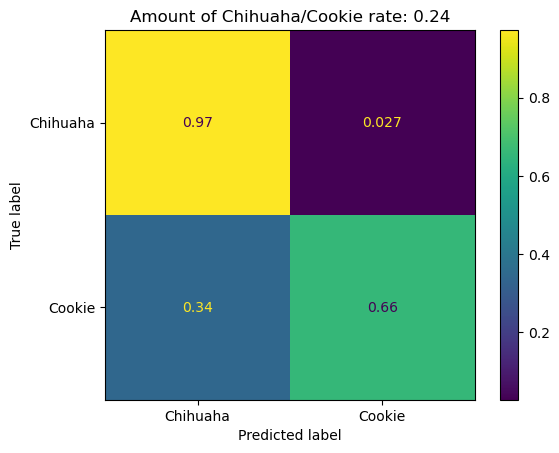

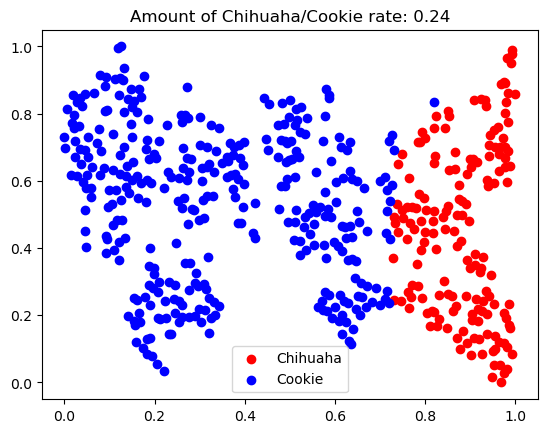

Weight balancing 1/4
Epoch 1/50
6/6 [==============================] - 11s 2s/step - loss: 0.4042 - accuracy: 0.6203 - val_loss: 3.5300 - val_accuracy: 0.5405
Epoch 2/50
6/6 [==============================] - 10s 2s/step - loss: 0.2442 - accuracy: 0.7086 - val_loss: 5.5740 - val_accuracy: 0.5405
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 0.1440 - accuracy: 0.8504 - val_loss: 1.0924 - val_accuracy: 0.5405
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 0.1197 - accuracy: 0.8898 - val_loss: 4.5176 - val_accuracy: 0.5405
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 0.0951 - accuracy: 0.9131 - val_loss: 1.9529 - val_accuracy: 0.5405
Epoch 6/50
6/6 [==============================] - 10s 2s/step - loss: 0.0828 - accuracy: 0.9157 - val_loss: 1.7706 - val_accuracy: 0.5405
Epoch 7/50
6/6 [==============================] - 10s 2s/step - loss: 0.0674 - accuracy: 0.9354 - val_loss: 1.1770 - val_accuracy: 0.5422
Epoch 8/50
6/

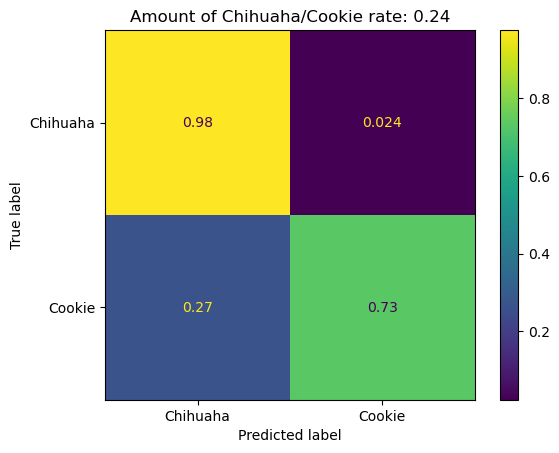

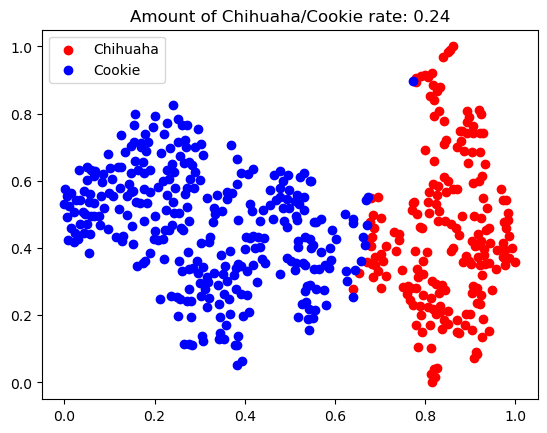

Found 3918 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1744, 2174]
Epoch 1/50
8/8 [==============================] - 16s 2s/step - loss: 1.6432 - accuracy: 0.5679 - val_loss: 4.9031 - val_accuracy: 0.4595
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.4390 - accuracy: 0.8096 - val_loss: 0.8306 - val_accuracy: 0.7154
Epoch 3/50
8/8 [==============================] - 15s 2s/step - loss: 0.3413 - accuracy: 0.8617 - val_loss: 0.7050 - val_accuracy: 0.7441
Epoch 4/50
8/8 [==============================] - 15s 2s/step - loss: 0.2768 - accuracy: 0.8923 - val_loss: 2.9793 - val_accuracy: 0.5405
Epoch 5/50
8/8 [==============================] - 14s 2s/step - loss: 0.2459 - accuracy: 0.9051 - val_loss: 4.9431 - val_accuracy: 0.5405
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.2205 - accuracy: 0.9170 - val_loss: 3.5484 - val_accuracy: 0.5405
Epoch 7/50
8/8 [==============================] - 15s

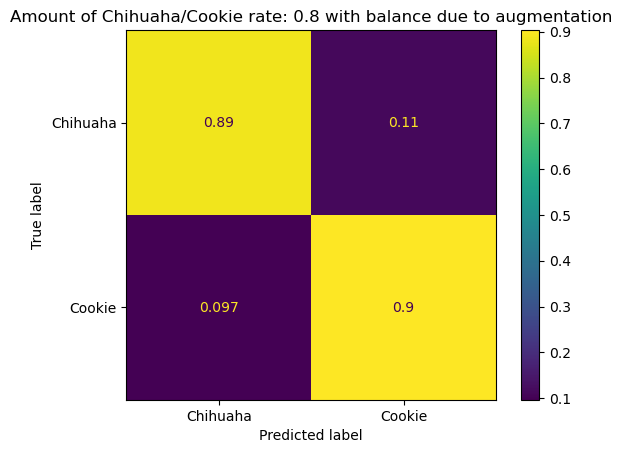

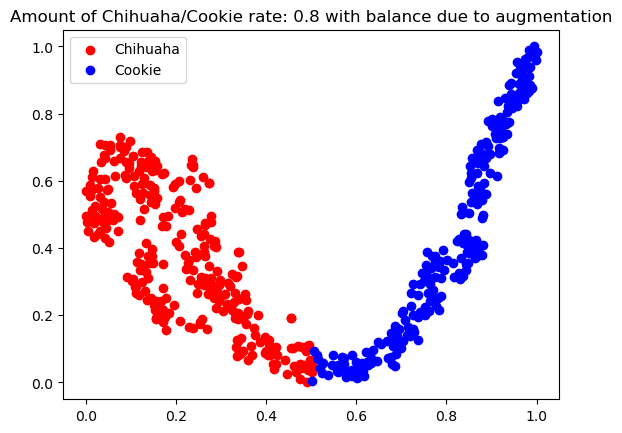

Found 3990 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1816, 2174]
Epoch 1/50
8/8 [==============================] - 16s 2s/step - loss: 1.5332 - accuracy: 0.5489 - val_loss: 4.1200 - val_accuracy: 0.5405
Epoch 2/50
8/8 [==============================] - 15s 2s/step - loss: 0.4277 - accuracy: 0.8211 - val_loss: 32.1675 - val_accuracy: 0.5405
Epoch 3/50
8/8 [==============================] - 15s 2s/step - loss: 0.3224 - accuracy: 0.8712 - val_loss: 17.2633 - val_accuracy: 0.5405
Epoch 4/50
8/8 [==============================] - 14s 2s/step - loss: 0.2724 - accuracy: 0.8980 - val_loss: 6.2617 - val_accuracy: 0.5405
Epoch 5/50
8/8 [==============================] - 15s 2s/step - loss: 0.2328 - accuracy: 0.9155 - val_loss: 6.4246 - val_accuracy: 0.5405
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.2094 - accuracy: 0.9246 - val_loss: 2.2226 - val_accuracy: 0.5422
Epoch 7/50
8/8 [==============================] - 1

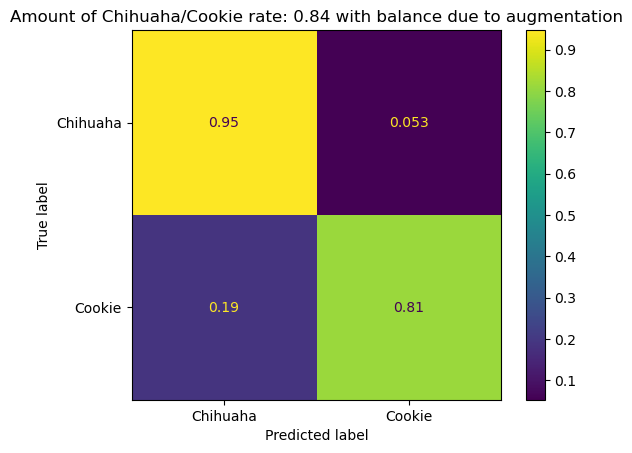

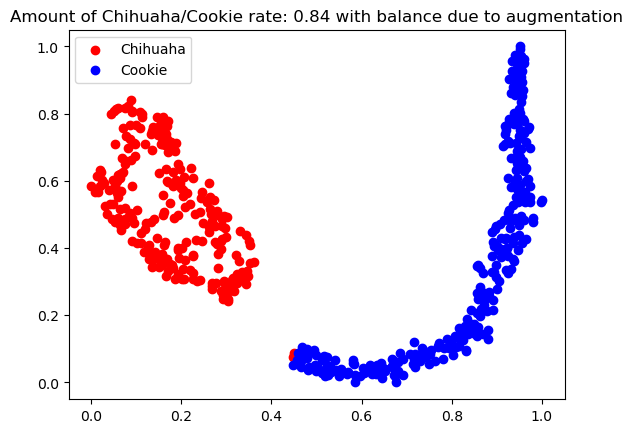

In [105]:
paths_to_test = ['muffinchi/train' ,'muffinchi/train_12' , 'muffinchi/train_14' ,'muffinchi/train_12aug' , 'muffinchi/train_14aug' ]
EPOCHS = 50

for path_to_test in paths_to_test: 
    experiment_string = ''
    train_dir = path_to_test
    test_dir = 'muffinchi/test'
    AUTOTUNE = tf.data.AUTOTUNE
    train_set = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=42,
        batch_size=512,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        image_size=(64, 64))
    test_set = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        batch_size=512,
        seed=42,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        image_size=(64, 64))
    
    class_names = train_set.class_names
    class_counts = [0] * len(class_names)
    for images, labels in train_set:
        for label in labels:
            class_counts[label] += 1
    print(class_names)
    print(class_counts)
    
    experiment_string = experiment_string + "Amount of Chihuaha/Cookie rate: " + str(round(class_counts[0]/class_counts[1], 2))
    if path_to_test == 'muffinchi/train_12aug' or path_to_test == 'muffinchi/train_14aug':
        experiment_string = experiment_string + ' with balance due to augmentation'

    train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
    test_set= test_set.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)
    normalized_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    
    
    model.load_weights("modelimage.h5")
    history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False)
    

    
    
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    
    

    y_true, y_pred = get_predictions_and_true_label(test_set, model,y_true, y_pred)
    
    report_data_image(y_pred,y_true,experiment_string)
    model.save('modelentireimage.h5')
    model = load_model("modelentireimage.h5" )
    TSNE_visualization_image(model, test_set, experiment_string)
    if path_to_test == 'muffinchi/train_12aug' or path_to_test == 'muffinchi/train_14aug':
        continue
    else:
        if path_to_test == 'muffinchi/train_12':
            print("Weight balancing 1/2")
            model.load_weights("modelimage.h5")
            history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False ,  class_weight= { 0 : 1 , 1 : 1/2 })
            
            y_pred = []  # store predicted labels
            y_true = []  # store true labels
            y_true, y_pred = get_predictions_and_true_label(test_set, model,y_true, y_pred)
            
            report_data_image(y_pred,y_true,experiment_string)
            model.save('modelentireimage.h5')
            model = load_model("modelentireimage.h5" )
            TSNE_visualization_image(model, test_set, experiment_string)
            
        elif path_to_test == 'muffinchi/train_14':
            print("Weight balancing 1/4")
            model.load_weights("modelimage.h5")
            history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False ,  class_weight= { 0 : 1 , 1 : 1/4 })
            
            y_pred = []  # store predicted labels
            y_true = []  # store true labels
            y_true, y_pred = get_predictions_and_true_label(test_set, model,y_true, y_pred)
            
            report_data_image(y_pred,y_true,experiment_string)
            model.save('modelentireimage.h5')
            model = load_model("modelentireimage.h5" )
            TSNE_visualization_image(model, test_set, experiment_string)
            


### 1.6.2 Conclusion and results

#### 1.6.2.1 quantitative results

Reference without Imbalance:
- Accuracy: 0.94
- F1-minority: 0.93
- No minor to majority class bias
- Clear seperation in t-SNE plot


| Accuracy  | no augmentations  | weight rebalancing  | Augmentations rebalancing  |
|---|---|---|---|
| Class imbalance 1/2  | 0.87  | 0.90  | 0.89  |
| Class imbalance 1/4   | 0.76  | 0.83  | 0.87  |



| f1-score (minority class) | no augmentations  | weight rebalancing  | Augmentations rebalancing  |
|---|---|---|---|
| Class imbalance 1/2  | 0.87  | 0.90  | 0.80  |
| Class imbalance 1/4   | 0.79  | 0.83  | 0.83  |


The results indicate that there is more benefit from augmentations over weight balancing in case of big differences in imbalance. Whenever the imbalance is low it is better to opt for weight balancing.
In all cases the results are worse than the full dataset as expected.

#### 1.6.2.2 Visual results
The visual results are the same for most of the experiments with one exception for the t-SNE plot for augmentation using a 1/4th imbalance.

##### 1.6.2.2.1 Confusion matrix
Overal there always remains a small bias from minor to major class in all cases of imbalance.

##### 1.6.2.2.2 t-SNE plot
The t-SNE plot shows strict boundouries that have larger borders with greater imbalance, hence making the decision boundary more difficult for the classifier. One exclusion from this being the augmented dataset using a 1/4th imbalance. Here there is no border at all and all values can be strictly seperated.




## 1.7 Overal conclusion
There is a strict trend between all experiments that there is a cutoff point on where augmentations and oversampling of the data provide a better alternative to weight balancing to the classes with less values. This can be oserved most of times when dealing with an imbalance of 1/4th or greater.


# 2. How does the incorporation of time series analysis techniques enhance the accuracy and forcasting capabilities of regression models for time-dependent data and how do they perform oposed to each other?

## 2.1 Experiment low dimensional data

The experiment data is generated as a regression and is then ordered from small to big values to have some control over the data.

The loss function used in the experiments is the rmse error, obtained with formula below:

$$ \text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}} $$

In [121]:

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt #for plotting

x, y, coef = datasets.make_regression(n_samples=1000,#number of samples
                                      n_features=1,#number of features
                                      n_informative=1,#number of useful features 
                                      noise=100000000,#bias and standard deviation of the guassian noise
                                      coef=True,#true coefficient used to generated the data
                                      random_state=0) #set for same data points for each run

# Scale feature x (years of experience) to range 0..20
x = np.interp(x, (x.min(), x.max()), (0, 20))
x = np.sort(x, axis = 0)


# Scale target y (salary) to range 20000..150000 
y = np.interp(y, (y.min(), y.max()), (20000, 150000))
y = np.sort(y, axis = 0)




dataframe_experiment = pd.DataFrame({'X': x.flatten(), 'Y': y}, columns=['X', 'Y'])
dataframe_experiment.head()

X        Y
0 0.00 20000.00
1 0.73 24470.63
2 0.94 29801.38
3 1.06 30727.74
4 1.33 36903.95

Then an optimal non optimezed regressor is searched with lazyregressor, due to time restrictions this is commented.

In [129]:

train_df, test_df = train_test_split(dataframe_experiment, test_size=0.5, shuffle=False)

X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

#reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
#models,predictions = reg.fit(X_train, X_test, y_train, y_test)
print(predictions)




                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
OrthogonalMatchingPursuitCV                  1.00       1.00     184.46   
LassoLars                                    1.00       1.00     203.27   
LassoCV                                      1.00       1.00     292.79   
OrthogonalMatchingPursuit                    1.00       1.00     322.16   
RANSACRegressor                              1.00       1.00     338.28   
HuberRegressor                               1.00       1.00     508.93   
Ridge                                        0.99       0.99     983.58   
PassiveAggressiveRegressor                   0.99       0.99    1402.15   
LassoLarsCV                                  0.99       0.99    1455.27   
SGDRegressor                                 0.98       0.98    1569.78   
BayesianRidge                                0.98       0.98    1623.32   
TransformedTargetRegresso

### 2.1.1 Huber-regressor 
Linear regression using the linear least squares method, uses squares to make the error as small as possible, Mathematically as follows:

$$R = \sum e_i^2 = \sum (y_i - \hat{y_i})^2 = \sum (y_i - b_0 - b_1x_i)^2 $$

Using derivatives the optimal values are searched, this value is where the derivative is equal to 0.

$$\frac{\partial R}{\partial b_0} = \sum 2(y_i - b_0 - b_1x_i)(-1) = 0$$

$$\frac{\partial R}{\partial b_1} = \sum 2(y_i - b_0 - b_1x_i)(-x_i) = 0$$

Huber tackles this problem differently to cope with outlier values, and assigns the loss function as follows  ($\delta$ is chosen arbitraly for each problem)   :

$$L_\delta (e_i) = \begin{cases}
 \frac{1}{2}{e_i^2}                   & \text{for } |e_i| \le \delta, \\
 \delta \cdot \left(|e_i| - \frac{1}{2}\delta\right), & \text{otherwise.}
\end{cases}$$

As in the least squares method here the errors for the coefficients will be minimized to enhance the regression.


In [130]:


huber = HuberRegressor().fit(X_train, y_train)
huber_pedictions_no_features = huber.predict(X_test)
print(huber.coef_)

[6194.47592377]


### 2.1.2 Time-series analysis techniques

#### 2.1.2.1 Simple moving average

$$SMA_k = \frac{1}{k} \sum_{i=0}^{n} p_i$$

A moving average is a sum of series of data points divided by the amount of data points.

#### 2.1.2.2 Cummulative moving average

This uses the same formula as a moving average, but the intent is different. Wheras a simple moving average accounts for k past data-points the cummulative moving average takes all past data-points.

#### 2.1.2.3 Exponential moving average

$$ewm_t = \frac{x_t + (1 - \alpha) x_{t-1} + (1 - \alpha)^2 x_{t-2} + \cdot \cdot \cdot + (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + \cdot \cdot \cdot + (1 - \alpha)^t}$$

The idea behind the exponential moving average is to give more weight and thus more importance to recent observations than past observations.


In [156]:
dataframe_experiment = pd.DataFrame({'X': x.flatten(), 'Y': y}, columns=['X', 'Y'])
dataframe_experiment.head()
train_df, test_df = train_test_split(dataframe_experiment, test_size=0.5, shuffle=False)



train_df['SMA2'] = train_df['Y'].rolling(2).mean()
train_df['SMA4'] = train_df['Y'].rolling(4).mean()
train_df['SMA8'] = train_df['Y'].rolling(8).mean()

train_df['SMA15'] = train_df['Y'].rolling(15).mean()
train_df['SMA30'] = train_df['Y'].rolling(30).mean()



train_df['CMA'] = train_df['Y'].expanding().mean()


train_df['EWMA4'] = train_df['Y'].ewm(4).mean()
train_df['EWMA8'] = train_df['Y'].ewm(8).mean()

train_df['EWMA15'] = train_df['Y'].ewm(15).mean()
train_df['EWMA30'] = train_df['Y'].ewm(30).mean()



test_df['SMA2'] = test_df['Y'].rolling(2).mean()
test_df['SMA4'] = test_df['Y'].rolling(4).mean()
test_df['SMA8'] = test_df['Y'].rolling(8).mean()

test_df['SMA15'] = test_df['Y'].rolling(15).mean()
test_df['SMA30'] = test_df['Y'].rolling(30).mean()



test_df['CMA'] = test_df['Y'].expanding().mean()


test_df['EWMA4'] = test_df['Y'].ewm(4).mean()
test_df['EWMA8'] = test_df['Y'].ewm(8).mean()

test_df['EWMA15'] = test_df['Y'].ewm(15).mean()
test_df['EWMA30'] = test_df['Y'].ewm(30).mean()


backup = train_df['Y']
train_df=train_df.loc[:,train_df.columns!='Y']
train_df['Y']= backup


backup = test_df['Y']
test_df=test_df.loc[:,test_df.columns!='Y']
test_df['Y']= backup

test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")

X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

#reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
#models,predictions = reg.fit(X_train, X_test, y_train, y_test)
#print(models)
huber = HuberRegressor().fit(X_train, y_train)
huber_pedictions_features = huber.predict(X_test)
print(huber.coef_)

[ 1.02317343e-05  8.00872546e-01  2.06771328e-01 -1.23804507e-01
  9.75847885e-02  4.33832695e-02  1.45797550e-02  1.65155665e-01
 -7.64058706e-02 -1.82614975e-01  5.73370440e-02]


In [132]:
# simple moving averages
test_df['SMA2'] = test_df['Y'].rolling(2).mean()
test_df['SMA4'] = test_df['Y'].rolling(4).mean()
test_df['SMA8'] = test_df['Y'].rolling(8).mean()

test_df['SMA15'] = test_df['Y'].rolling(15).mean()
test_df['SMA30'] = test_df['Y'].rolling(30).mean()



test_df['CMA'] = test_df['Y'].expanding().mean()


test_df['EWMA4'] = test_df['Y'].ewm(4).mean()
test_df['EWMA8'] = test_df['Y'].ewm(8).mean()

test_df['EWMA15'] = test_df['Y'].ewm(15).mean()
test_df['EWMA30'] = test_df['Y'].ewm(30).mean()

<Axes: xlabel='X'>

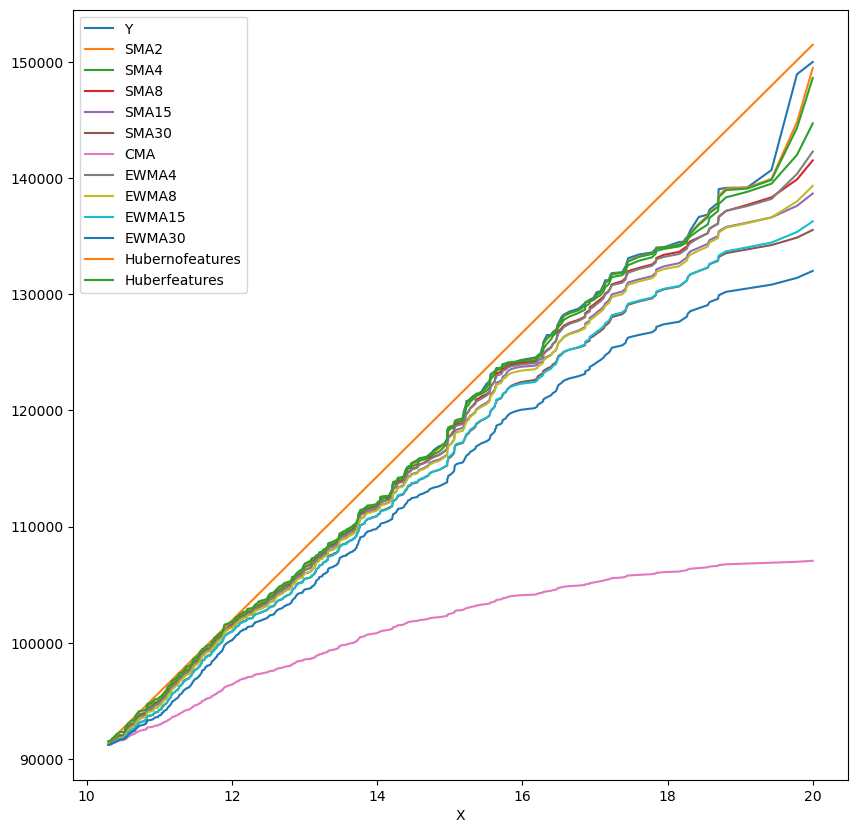

In [133]:
test_df['Hubernofeatures'] = huber_pedictions_no_features
test_df["Huberfeatures"] = huber_pedictions_features

test_df.plot(x="X", y=["Y","SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Hubernofeatures' , 'Huberfeatures'],kind="line", figsize=(10, 10))
 


In [134]:
def calculate_multiple_rmse(df,rmse_columns,targetname):
    rmse_dict = {}
    for column in rmse_columns:
        realVals = df[targetname]
        predictedVals = df[column]
        mse = mean_squared_error(realVals, predictedVals, squared=False)
        rmse_dict[column] = mse
    return {k: v for k, v in sorted(rmse_dict.items(), key=lambda item: item[1])}


In [135]:
test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")
print(calculate_multiple_rmse(test_df,["SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Hubernofeatures' , 'Huberfeatures'],"Y"))

{'SMA2': 206.6361994643709, 'Huberfeatures': 284.75469627660675, 'SMA4': 447.1340469676914, 'EWMA4': 719.3967831410464, 'SMA8': 724.0922080243653, 'SMA15': 1117.1168897821028, 'EWMA8': 1156.1380068779508, 'Hubernofeatures': 1758.2050639508518, 'EWMA15': 1836.9799573137204, 'SMA30': 1870.8770274129768, 'EWMA30': 3102.8762123112483, 'CMA': 12018.806544513003}


### 2.1.3 Conclusion
Observations show that SMA2 gives the best result, this comes to no suprise since the data is sorted from small to big and this is a calculation based on the current value and the previous value and thus having almost all informations to make a perfect prediction (An SMA of 1 has a perfect prediction, and rmse of 0). However using a half cut split a huberregressor with half of the data performs worse than a moving average based on 15 succeeding data-points. This is interesting because by simply looking at past results a big gain could be made into predicting future events, thus increasing the importance of using moving averages. It can be seen that the Huber regressor benefits with a substantial amount by using time series analysis techniques.  

## 2.2 Experiment with high dimensional tabular data
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

Again the same setup is made with exception that now there are more features to learn and thus it is interesting wther these features will overule the need of time series analysis techniques to aid a model.

In [172]:
dataframe_experiment = pd.read_csv('energydata_complete.csv')
dataframe_experiment['year'] = pd.to_datetime(dataframe_experiment['date']).dt.year
dataframe_experiment['month'] = pd.to_datetime(dataframe_experiment['date']).dt.month
dataframe_experiment['day'] = pd.to_datetime(dataframe_experiment['date']).dt.day
dataframe_experiment['hour'] = pd.to_datetime(dataframe_experiment['date']).dt.hour
dataframe_experiment['minute'] = pd.to_datetime(dataframe_experiment['date']).dt.minute
dataframe_experiment['second'] = pd.to_datetime(dataframe_experiment['date']).dt.second
dataframe_experiment = dataframe_experiment.drop('date', axis=1)

In [173]:
train_df, test_df = train_test_split(dataframe_experiment, test_size=0.6, shuffle=False)




X_train = train_df.iloc[:, :]
y_train = train_df.loc[:, 'Appliances']
X_train = train_df.drop('Appliances', axis=1)


X_test = test_df.iloc[:, :]
y_test = test_df.loc[:, 'Appliances']
X_test = test_df.drop('Appliances', axis=1)


In [174]:
#reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
#models,predictions = reg.fit(X_train, X_test, y_train, y_test)
display(train_df)

Appliances  lights    T1  RH_1    T2  RH_2    T3  RH_3    T4  RH_4  ...  \
0             60      30 19.89 47.60 19.20 44.79 19.79 44.73 19.00 45.57  ...   
1             60      30 19.89 46.69 19.20 44.72 19.79 44.79 19.00 45.99  ...   
2             50      30 19.89 46.30 19.20 44.63 19.79 44.93 18.93 45.89  ...   
3             50      40 19.89 46.07 19.20 44.59 19.79 45.00 18.89 45.72  ...   
4             60      40 19.89 46.33 19.20 44.53 19.79 45.00 18.89 45.53  ...   
...          ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
7889          70       0 19.20 39.00 17.60 40.76 19.89 37.40 21.13 36.69  ...   
7890          70       0 19.32 39.06 17.73 40.93 19.89 37.43 21.07 36.53  ...   
7891          90      20 19.39 39.06 17.86 40.79 19.82 37.43 20.86 36.59  ...   
7892          90      30 19.43 39.09 17.93 40.53 19.79 37.43 20.70 36.63  ...   
7893          90      20 19.50 39.03 18.02 40.34 19.79 37.50 20.63 36.70  ...   

      Visibility  Tdewpoint   rv1   rv2  year  month  day  hour  minute  \
0          63.00       5.30 13.28 13.28  2016      1   11    17       0   
1          59.17       5.20 18.61 18.61  2016      1   11    17      10   
2          55.33       5.10 28.64 28.64  2016      1   11    17      20   
3          51.50       5.00 45.41 45.41  2016      1   11    17      30   
4          47.67       4.90 10.08 10.08  2016      1   11    17      40   
...          ...        ...   ...   ...   ...    ...  ...   ...     ...   
7889       37.00       2.32 31.59 31.59  2016      3    6    11      50   
7890       40.00       2.40 32.88 32.88  2016      3    6    12       0   
7891       40.00       2.52 43.02 43.02  2016      3    6    12      10   
7892       40.00       2.63 19.91 19.91  2016      3    6    12      20   
7893       40.00       2.75 42.43 42.43  2016      3    6    12      30   

      second  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
7889       0  
7890       0  
7891       0  
7892       0  
7893       0  

[7894 rows x 34 columns]

In [168]:
def objective(trial):
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 2, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=20,verbose=False)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse



In [141]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-23 01:17:03,457] A new study created in memory with name: no-name-15f3fbd8-a04c-4743-b253-57eafe5c3175
[I 2023-05-23 01:17:03,859] Trial 0 finished with value: 91.80513010487645 and parameters: {'reg_alpha': 0.0022715620733996535, 'reg_lambda': 2.375674080129492, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 618, 'min_child_samples': 192, 'cat_smooth': 64}. Best is trial 0 with value: 91.80513010487645.
[I 2023-05-23 01:17:04,049] Trial 1 finished with value: 91.98127457879474 and parameters: {'reg_alpha': 0.001827974303513484, 'reg_lambda': 0.0016863151206182336, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 958, 'min_child_samples': 287, 'cat_smooth': 59}. Best is trial 0 with value: 91.80513010487645.
[I 2023-05-23 01:17:04,288] Trial 2 finished with value: 92.3915132534561 and parameters: {'reg_alpha': 0.12943394949795678, 'reg_lambda': 0.20458372135004876, 'colsample_

Number of finished trials: 50
Best trial: {'reg_alpha': 0.1442296900658637, 'reg_lambda': 2.074383975322896, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 555, 'min_child_samples': 97, 'cat_smooth': 51}


### 2.2.1 Tweedie regressor

The tweedie regressor uses Tweedie loss to optimize its fit to data, this is done with following formula:
$$L = \sum_{i=1}^n w_i \left(-\frac{y_i \exp{(F(x_i)(1-\rho))}}{1 - \rho} + \frac{\exp{(F(x_i)(2-\rho))}}{2 - \rho}\right) $$

- $y_i$: target value
- $w_i$: Feature weight
- $F(x_i)$: Current target prediction
- $\rho$: Parameter to optimize the tweedie regressor

https://github.com/catboost/tutorials/blob/master/regression/tweedie.ipynb

### 2.2.2 Lightgbm regressor

Lightgbm is a highly optimized gradient boosting framework that uses tree based algrithms.

https://lightgbm.readthedocs.io/en/v3.3.2/

In [145]:


tweedie = linear_model.TweedieRegressor().fit(X_train, y_train)
tweedie_pedictions_no_features = tweedie.predict(X_test)

In [146]:
params=study.best_params   
print(params)

{'reg_alpha': 0.00650753585219822, 'reg_lambda': 0.001030806256348579, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 321, 'min_child_samples': 94, 'cat_smooth': 29}


In [147]:
lgb = LGBMRegressor(**params).fit(X_train, y_train)
lgb_pedictions_no_features = lgb.predict(X_test)

In [175]:
train_df['SMA2'] = train_df['Appliances'].rolling(2).mean()
train_df['SMA4'] = train_df['Appliances'].rolling(4).mean()
train_df['SMA8'] = train_df['Appliances'].rolling(8).mean()

train_df['SMA15'] = train_df['Appliances'].rolling(15).mean()
train_df['SMA30'] = train_df['Appliances'].rolling(30).mean()



train_df['CMA'] = train_df['Appliances'].expanding().mean()


train_df['EWMA4'] = train_df['Appliances'].ewm(4).mean()
train_df['EWMA8'] = train_df['Appliances'].ewm(8).mean()

train_df['EWMA15'] = train_df['Appliances'].ewm(15).mean()
train_df['EWMA30'] = train_df['Appliances'].ewm(30).mean()



test_df['SMA2'] = test_df['Appliances'].rolling(2).mean()
test_df['SMA4'] = test_df['Appliances'].rolling(4).mean()
test_df['SMA8'] = test_df['Appliances'].rolling(8).mean()

test_df['SMA15'] = test_df['Appliances'].rolling(15).mean()
test_df['SMA30'] = test_df['Appliances'].rolling(30).mean()



test_df['CMA'] = test_df['Appliances'].expanding().mean()


test_df['EWMA4'] = test_df['Appliances'].ewm(4).mean()
test_df['EWMA8'] = test_df['Appliances'].ewm(8).mean()

test_df['EWMA15'] = test_df['Appliances'].ewm(15).mean()
test_df['EWMA30'] = test_df['Appliances'].ewm(30).mean()


backup = train_df['Appliances']
train_df=train_df.loc[:,train_df.columns!='Appliances']
train_df['Appliances']= backup


backup = test_df['Appliances']
test_df=test_df.loc[:,test_df.columns!='Appliances']
test_df['Appliances']= backup

test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")

X_train = train_df.iloc[:, :]
y_train = train_df.loc[:, 'Appliances']
X_train = train_df.drop('Appliances', axis=1)


X_test = test_df.iloc[:, :]
y_test = test_df.loc[:, 'Appliances']
X_test = test_df.drop('Appliances', axis=1)

In [177]:
display(train_df)
display(X_train)

lights    T1  RH_1    T2  RH_2    T3  RH_3    T4  RH_4    T5  ...  SMA4  \
0         30 19.89 47.60 19.20 44.79 19.79 44.73 19.00 45.57 17.17  ... 55.00   
1         30 19.89 46.69 19.20 44.72 19.79 44.79 19.00 45.99 17.17  ... 55.00   
2         30 19.89 46.30 19.20 44.63 19.79 44.93 18.93 45.89 17.17  ... 55.00   
3         40 19.89 46.07 19.20 44.59 19.79 45.00 18.89 45.72 17.17  ... 55.00   
4         40 19.89 46.33 19.20 44.53 19.79 45.00 18.89 45.53 17.20  ... 55.00   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7889       0 19.20 39.00 17.60 40.76 19.89 37.40 21.13 36.69 17.50  ... 67.50   
7890       0 19.32 39.06 17.73 40.93 19.89 37.43 21.07 36.53 17.50  ... 65.00   
7891      20 19.39 39.06 17.86 40.79 19.82 37.43 20.86 36.59 17.50  ... 72.50   
7892      30 19.43 39.09 17.93 40.53 19.79 37.43 20.70 36.63 17.50  ... 80.00   
7893      20 19.50 39.03 18.02 40.34 19.79 37.50 20.63 36.70 17.50  ... 85.00   

      SMA8  SMA15  SMA30   CMA  EWMA4  EWMA8  EWMA15  EWMA30  Appliances  
0    56.25 144.67 126.67 60.00  60.00  60.00   60.00   60.00          60  
1    56.25 144.67 126.67 60.00  60.00  60.00   60.00   60.00          60  
2    56.25 144.67 126.67 56.67  55.90  56.27   56.45   56.56          50  
3    56.25 144.67 126.67 55.00  53.90  54.41   54.68   54.84          50  
4    56.25 144.67 126.67 56.00  55.72  55.81   55.88   55.94          60  
...    ...    ...    ...   ...    ...    ...     ...     ...         ...  
7889 70.00  66.67  54.33 97.71  67.11  62.72   57.57   57.28          70  
7890 72.50  67.33  55.00 97.71  67.69  63.53   58.34   57.69          70  
7891 76.25  68.67  56.00 97.71  72.15  66.47   60.32   58.74          90  
7892 77.50  68.67  57.33 97.71  75.72  69.08   62.18   59.74          90  
7893 76.25  69.33  59.00 97.71  78.58  71.41   63.92   60.72          90  

[7894 rows x 44 columns]

lights    T1  RH_1    T2  RH_2    T3  RH_3    T4  RH_4    T5  ...  SMA2  \
0         30 19.89 47.60 19.20 44.79 19.79 44.73 19.00 45.57 17.17  ... 60.00   
1         30 19.89 46.69 19.20 44.72 19.79 44.79 19.00 45.99 17.17  ... 60.00   
2         30 19.89 46.30 19.20 44.63 19.79 44.93 18.93 45.89 17.17  ... 55.00   
3         40 19.89 46.07 19.20 44.59 19.79 45.00 18.89 45.72 17.17  ... 50.00   
4         40 19.89 46.33 19.20 44.53 19.79 45.00 18.89 45.53 17.20  ... 55.00   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7889       0 19.20 39.00 17.60 40.76 19.89 37.40 21.13 36.69 17.50  ... 65.00   
7890       0 19.32 39.06 17.73 40.93 19.89 37.43 21.07 36.53 17.50  ... 70.00   
7891      20 19.39 39.06 17.86 40.79 19.82 37.43 20.86 36.59 17.50  ... 80.00   
7892      30 19.43 39.09 17.93 40.53 19.79 37.43 20.70 36.63 17.50  ... 90.00   
7893      20 19.50 39.03 18.02 40.34 19.79 37.50 20.63 36.70 17.50  ... 90.00   

      SMA4  SMA8  SMA15  SMA30   CMA  EWMA4  EWMA8  EWMA15  EWMA30  
0    55.00 56.25 144.67 126.67 60.00  60.00  60.00   60.00   60.00  
1    55.00 56.25 144.67 126.67 60.00  60.00  60.00   60.00   60.00  
2    55.00 56.25 144.67 126.67 56.67  55.90  56.27   56.45   56.56  
3    55.00 56.25 144.67 126.67 55.00  53.90  54.41   54.68   54.84  
4    55.00 56.25 144.67 126.67 56.00  55.72  55.81   55.88   55.94  
...    ...   ...    ...    ...   ...    ...    ...     ...     ...  
7889 67.50 70.00  66.67  54.33 97.71  67.11  62.72   57.57   57.28  
7890 65.00 72.50  67.33  55.00 97.71  67.69  63.53   58.34   57.69  
7891 72.50 76.25  68.67  56.00 97.71  72.15  66.47   60.32   58.74  
7892 80.00 77.50  68.67  57.33 97.71  75.72  69.08   62.18   59.74  
7893 85.00 76.25  69.33  59.00 97.71  78.58  71.41   63.92   60.72  

[7894 rows x 43 columns]

In [178]:
def objective(trial):
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 2, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=30,verbose=False)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse

In [179]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   
print(params)

[I 2023-05-23 01:33:46,834] A new study created in memory with name: no-name-995bfc87-5793-46d8-ae68-49a0c5bb4396
[I 2023-05-23 01:33:47,632] Trial 0 finished with value: 34.84219710558707 and parameters: {'reg_alpha': 0.001738731262204592, 'reg_lambda': 0.002940285553235101, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 150, 'min_child_samples': 180, 'cat_smooth': 21}. Best is trial 0 with value: 34.84219710558707.
[I 2023-05-23 01:33:49,830] Trial 1 finished with value: 31.684473579078645 and parameters: {'reg_alpha': 4.942606554877133, 'reg_lambda': 0.001386198305085564, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 81, 'cat_smooth': 42}. Best is trial 1 with value: 31.684473579078645.
[I 2023-05-23 01:33:51,326] Trial 2 finished with value: 32.83998087651072 and parameters: {'reg_alpha': 0.0683908563908661, 'reg_lambda': 0.027373841039188444, 'colsample_b

LightGBMError: Check failed: (num_leaves) > (1) at D:\a\1\s\python-package\compile\src\io\config_auto.cpp, line 334 .


In [180]:
lgb = LGBMRegressor(**params).fit(X_train, y_train)
lgb_pedictions_features = lgb.predict(X_test)

In [181]:
tweedie = linear_model.TweedieRegressor().fit(X_train, y_train)
tweedie_pedictions_features = tweedie.predict(X_test)

<Axes: >

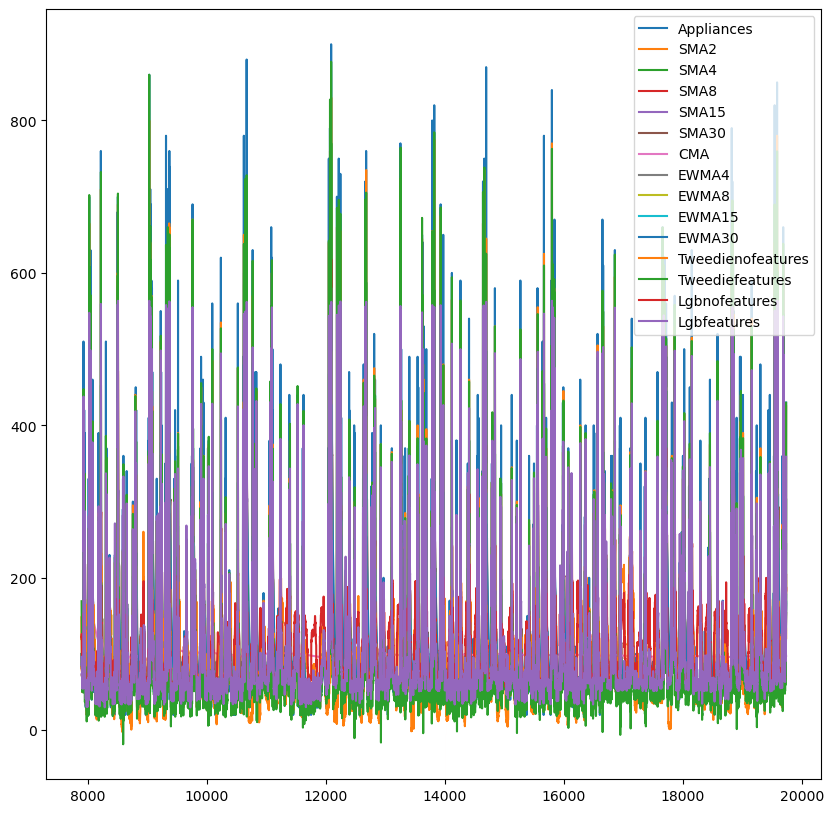

In [182]:
test_df['Tweedienofeatures'] = tweedie_pedictions_no_features
test_df["Tweediefeatures"] = tweedie_pedictions_features

test_df['Lgbnofeatures'] = lgb_pedictions_no_features
test_df["Lgbfeatures"] = lgb_pedictions_features

test_df.plot(use_index=True, y=['Appliances',"SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Tweedienofeatures' , 'Tweediefeatures' , "Lgbnofeatures" , "Lgbfeatures"],kind="line", figsize=(10, 10))

In [183]:
test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")
print(calculate_multiple_rmse(test_df,["SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Tweedienofeatures' , 'Tweediefeatures' , "Lgbnofeatures" , "Lgbfeatures"],'Appliances'))

{'Tweediefeatures': 31.50241705612098, 'SMA2': 35.0312032901008, 'Lgbfeatures': 35.60894372972865, 'SMA4': 58.62055887062029, 'EWMA4': 60.30680458768878, 'EWMA8': 70.45420867222279, 'SMA8': 71.22903384756715, 'SMA15': 77.08270442342108, 'EWMA15': 78.64091961465084, 'EWMA30': 86.38643328530924, 'SMA30': 86.55194903722322, 'Lgbnofeatures': 91.24778491199646, 'Tweedienofeatures': 97.20584518028728, 'CMA': 98.07196385728355}


<Axes: >

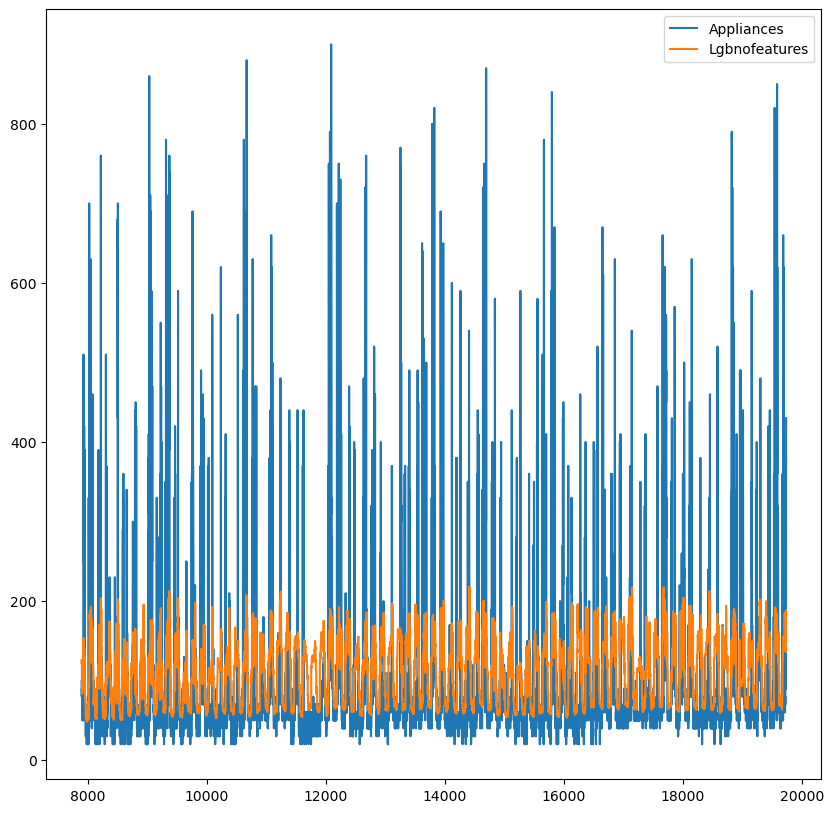

In [184]:
test_df.plot(use_index=True, y=['Appliances',"Lgbnofeatures"],kind="line", figsize=(10, 10))

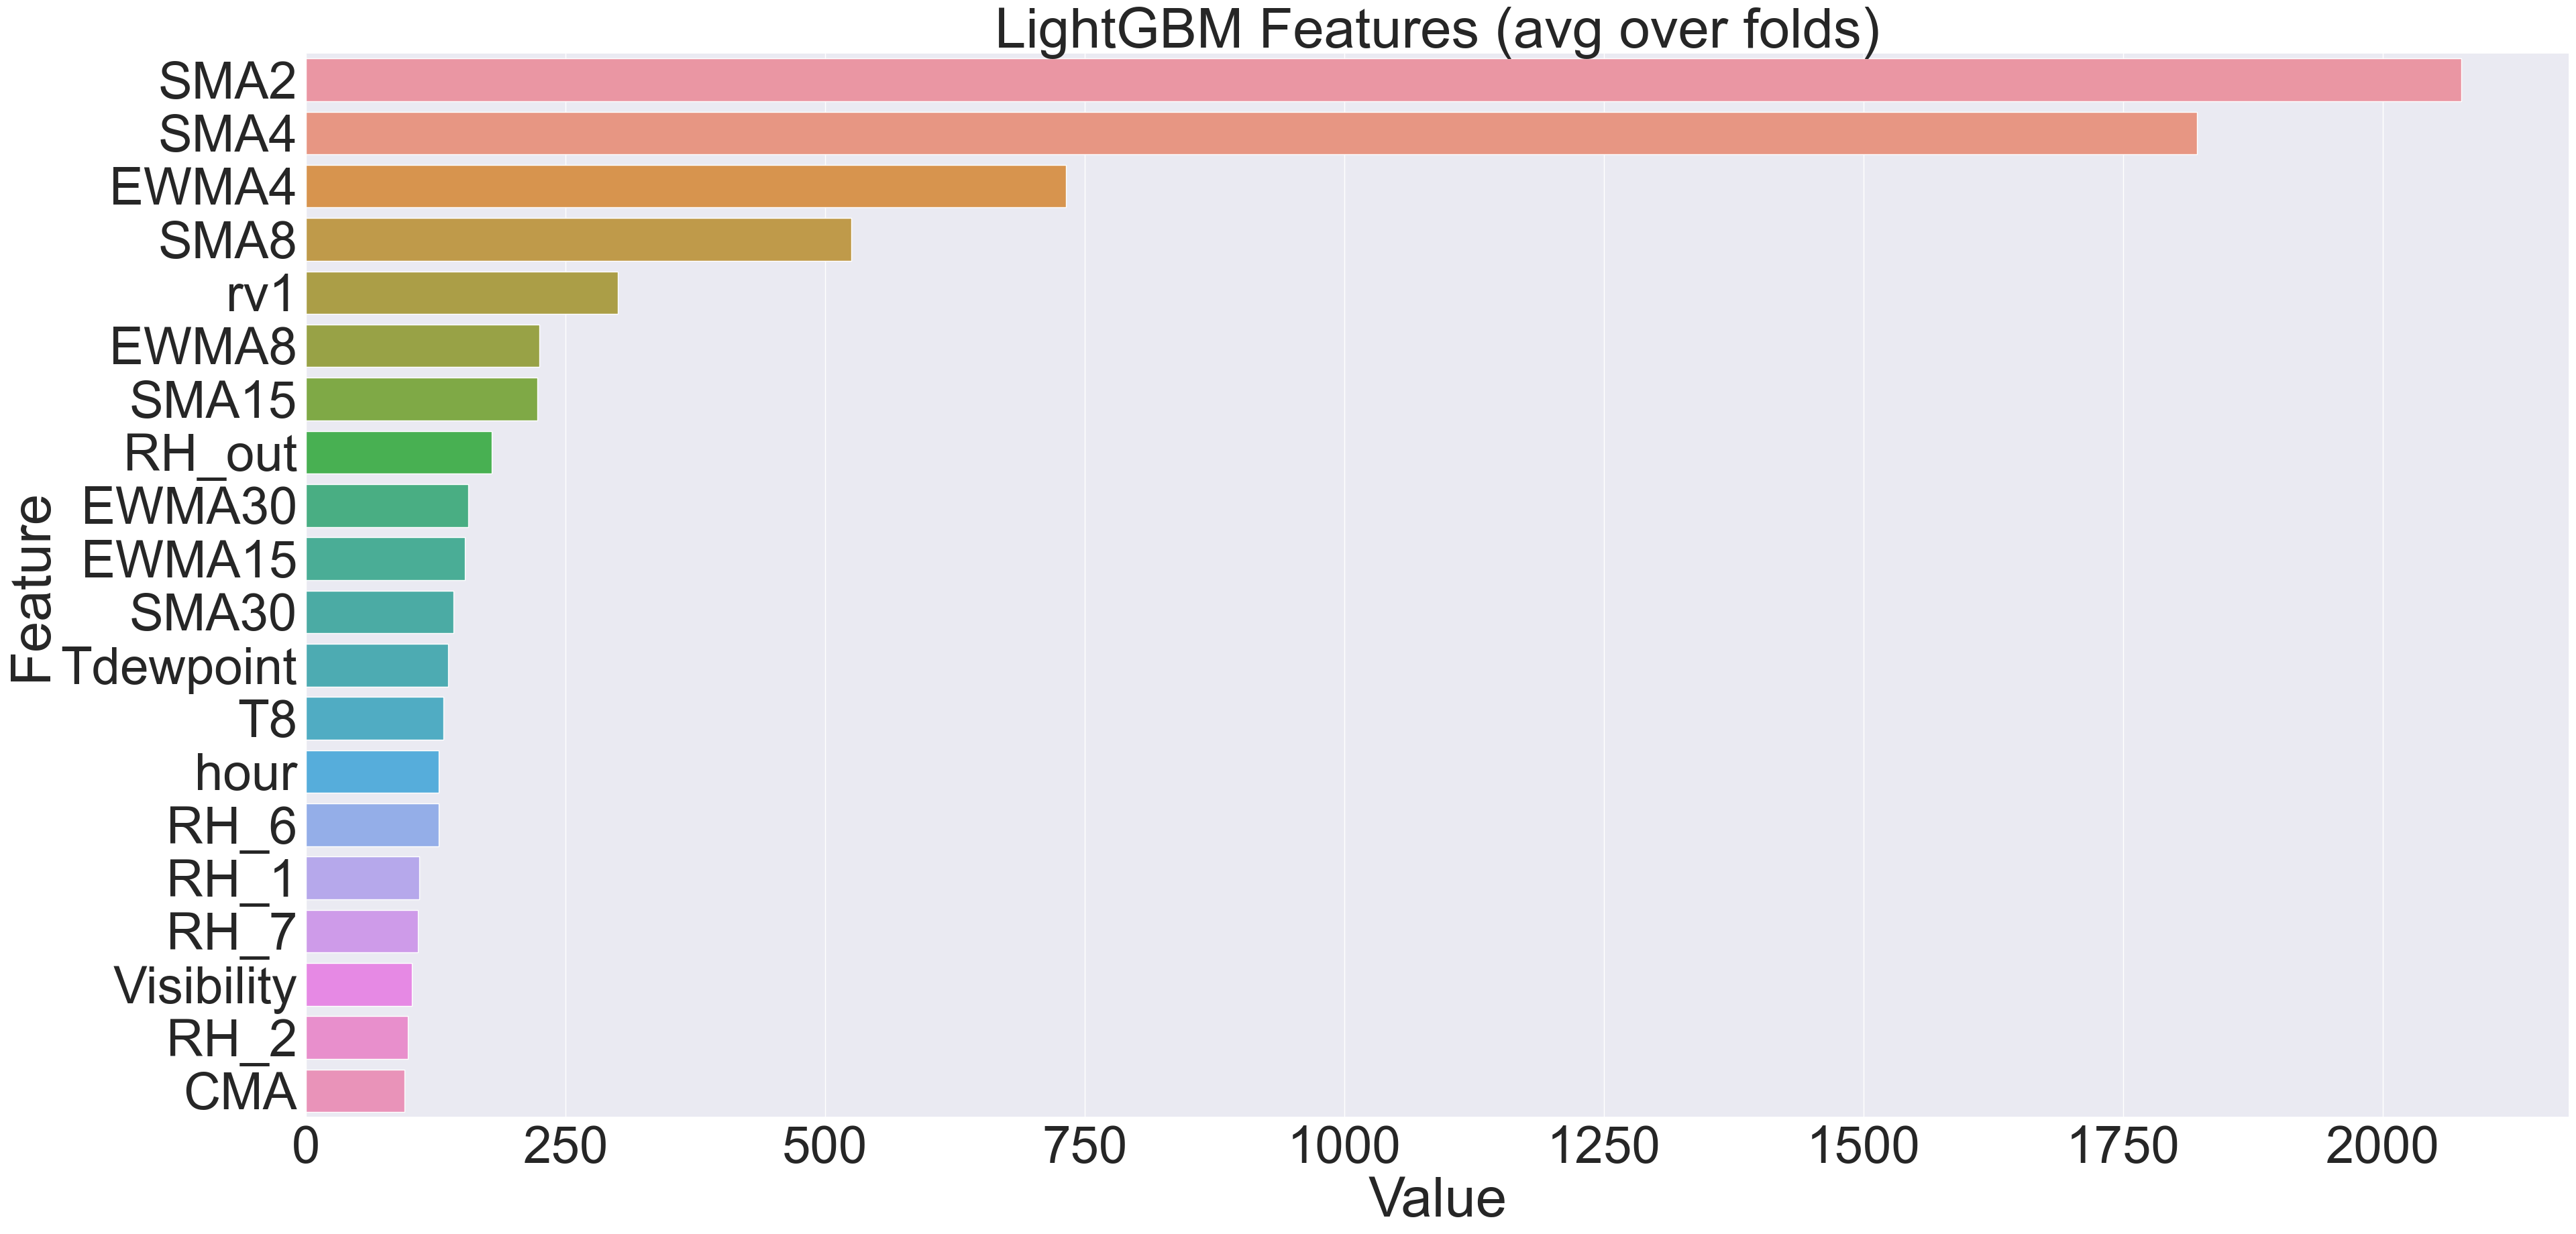

In [186]:
def plotImp(model, X_test , num = 20, fig_size = (40, 20)):

    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_test.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(lgb.booster_, X_test , num = 20, fig_size = (40, 20))  

### 2.2.3 Conclusion
For highly dimensional data it is clear that for the tweedieregressor as the lightgbm regressor both benefit strongly of these time series analysis techniques. Both performing worse than exponential moving averages and simple moving averages taken over a period of 30 days. Indicating that if possible, these time analysis tools perform a strong benefit. It can even be seen that when plottting the feature importances of the lightgbm regressor, a strong preference is given to the newly added time aalysis tools.

## 2.3 Overal conclusion

However a lot of feature engineering could have been done, scaling features, scaling the target value, incorperating weekends and weekdays adding working hours, etc etc. It can be seen that by simply relying on the past gotten results a very good prediction can be made. And when possible is

# 3. Automatic Feature Extraction in Convolution Neural Networks vs Manual Feature Extraction: Can Manual Feature Extraction outperform CNN's?

With CNNs being able to extract features from an input image (pixel dependencies etc.), are manual feature extraction methods obsolete? According to [this](https://datascience.stackexchange.com/questions/62409/is-manual-feature-extraction-outdated) stackexchange thread, it is not. We will test CNNs on image data and compare the results with using manual feature extraction (Grayscale values, mean channel value, edge detection) in combination with a more traditional ML algorithm: Decision trees.

We are especially interested in:
- The difference between E_in and E_out per method, as datasets with huge amount of features (such as images) might lead to model overfitting
- Differences between the errors of both methods
- To what extent is manual feature extraction still relevant in the case of image classification?
- What is the impact of different feature extraction techniques on model performance?

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D ,Input, InputLayer, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from skimage import filters, feature
from skimage.io import imread, imshow

import tensorflow as tf
import pandas as pd
import numpy as np


## 3.1 Footwear Image data
Dataset is from [kaggle](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images). It is an image classification problem with 3 classes: boot, sandal, shoe. It consists of 15k samples (5k samples of each class). The images are in RGB and of size 128x128. The orientation of all footwear in the dataset is the same, as well as the background (white). This should result in the models being able to learn without any image augmentation and still get high accuracy on the validation/test set. 

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './footwear_data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)
print(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.
['Boot', 'Sandal', 'Shoe']


### 3.1.1 Convolutional Neural Network

We will use the same network architecture used for 1.6. The algorithm is explained in the beginning of section 1.5. Due to the use of convolutional layers, the network will learn what features are important by itself only using the fact that neighbouring pixels have some codependence. This means that image samples can be fed as-is through the network.

We use early stopping. This means that the algorithm stops training if no improvement to the validation accuracy is made over a set amount of epochs.

In [ ]:
EPOCHS = 100

data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2)
])

model = Sequential([
    Rescaling(1./255),
    data_augmentation,
    #InputLayer(input_shape = (128,128,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax') # use softmax because we have 3 classes instead of 2 (as in 1.7)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build((batch_size, img_height, img_width, 3))
#model.save_weights("shoemodel.h5")
model.load_weights('shoemodel.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 128, 128, 3)         0         
                                                                 
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 128, 128, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (32, 128, 128, 32)       128       
 hNormalization)                                      

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/100
375/375 [==============================] - 803s 2s/step - loss: 0.8659 - accuracy: 0.6409 - val_loss: 1.4428 - val_accuracy: 0.4340
Epoch 2/100
375/375 [==============================] - 784s 2s/step - loss: 0.5411 - accuracy: 0.7777 - val_loss: 3.2184 - val_accuracy: 0.4097
Epoch 3/100
375/375 [==============================] - 790s 2s/step - loss: 0.4217 - accuracy: 0.8347 - val_loss: 2.7795 - val_accuracy: 0.3960
Epoch 4/100
375/375 [==============================] - 779s 2s/step - loss: 0.3788 - accuracy: 0.8547 - val_loss: 1.6511 - val_accuracy: 0.3747
Epoch 5/100
375/375 [==============================] - 833s 2s/step - loss: 0.3449 - accuracy: 0.8688 - val_loss: 0.5662 - val_accuracy: 0.8037
Epoch 6/100
375/375 [==============================] - 706s 2s/step - loss: 0.2885 - accuracy: 0.8928 - val_loss: 4.1695 - val_accuracy: 0.3457
Epoch 7/100
375/375 [==============================] - 739s 2s/step - loss: 0.2704 - accuracy: 0.9008 - val_loss: 1.0304 - val_accuracy:

#### Degree of generalization
The difference between in-sample and out-sample error corresponds to the difference between loss and val_loss (epoch 8) => |1 - 0.2466 - (1 - 0.2452)| = 0.0014. This shows that our model is able to generalize very well.

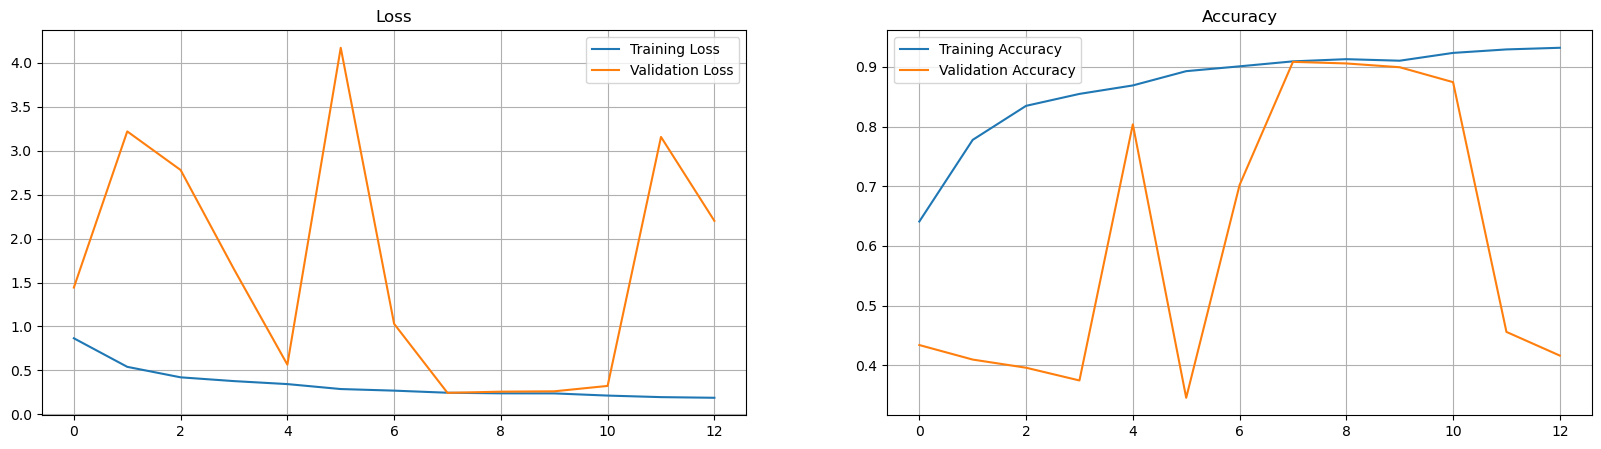

In [ ]:
cnn_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(cnn_data.loss, label='Training Loss')
plt.plot(cnn_data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_data.accuracy, label='Training Accuracy')
plt.plot(cnn_data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

1/1 [==============================] - 0s 384ms/step
              precision    recall  f1-score   support

           0     0.9585    0.9528    0.9556      1017
           1     0.9479    0.8298    0.8849       987
           2     0.8329    0.9408    0.8835       996

    accuracy                         0.9083      3000
   macro avg     0.9131    0.9078    0.9080      3000
weighted avg     0.9133    0.9083    0.9084      3000



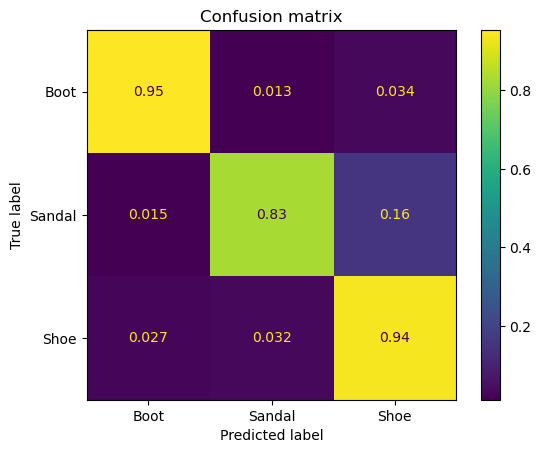

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
accuracy = test_accuracy * 100

# slightly different functions as in 1.6 due to 3-class classification

def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')
    
    
def get_predictions_and_true_label(test_set, model):
    # iterate over the dataset
    y_pred = []
    for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
        # compute predictions
        preds = model.predict(image_batch)

        # append predicted labels
        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
        
    y_true = np.concatenate([y for x, y in test_set], axis=0)
    
    return y_true, y_pred

y_true, y_pred = get_predictions_and_true_label(val_ds, model)

report_data_image(y_pred, y_true)

1/1 [==============================] - 0s 288ms/step


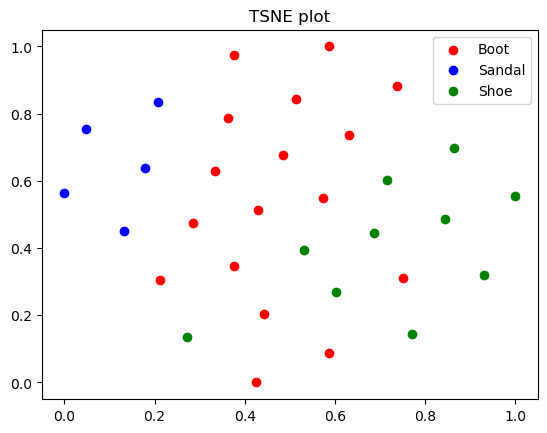

In [ ]:
def TSNE_visualization_image(model, testX, title):
    

    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    y_pred = []
    for p, _ in testX.take(1): # Takes 1 batch
        features = model2(p)         # Predict 1 batch
        preds = model.predict(p)

        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
    
    labels = y_pred

    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):
        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range
    
    def shrink_vector(vector, max_val):
        replacement = []
        for i in vector:
            if i > max_val:
                break
            else:
                replacement.append(i)
        return replacement

    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue', 'green']
    classes = ["Boot" , "Sandal", "Shoe"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        indices = shrink_vector(indices, len(tx) - 1)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()



TSNE_visualization_image(model, val_ds, 'TSNE plot')

From our experiments it is clear that CNN is able to classify the dataset very well with a validation accuracy of around 90%. The performance could still be improved (to around [97%](https://www.kaggle.com/code/venkatganesh98/shoevsbootvssandal-classification-cnn-acc-97#4.Model-Building)), but our results suffice for a good baseline to compare against.

### 3.1.2 Random forest classification
Random forest is an ensemble of decision trees. Decision trees work by iteratively splitting the dataset based on the available features. This split is done based on metrics (might differ per algo) that determine the quality of the split. We used the Gini impurity. The Gini impurity intuitively corresponds to number between 0 and 0.5 and indicates the likelihood of new, random data being misclassified if it were given a random label according to the class distribution in the dataset. This means that features with lower impurity are better to use as next split decision in the tree. Mathematically this corresponds to:
$$ Gini(D) = 1 - \sum_{i=1}^k p^2_i $$
For dataset D, with $p_i$ the probability of samples belonging to class i at a given node and k the amount of classes. The Gini impurity for attribute A that divides D into two subsets $D_1$ and $D_2$, with sizes $n_1$ and $n_2$ respectively, is defined as:
$$ Gini_A(D) = \frac{n_1}{n}Gini(D_1) + \frac{n_2}{n}Gini(D_2) $$
The attribute that minimizes this amount is chosen for the split. Also, the information gain according to Gini impurity can be defined as:
$$ \Delta Gini(A) = Gini(D) - Gini_A(D) $$
The best attribute for splitting is chosen based on maximizing this equation in that case.

Nodes are split until a max tree depth is specified or a minimum leaf size. These are the most important hyperparameters as they can severely reduce overfitting, which is a notorious property of decision trees. Decision trees are prone to overfitting on large datasets with a lot of features because of the amount of specific paths from root to leafs (overfitting = bad generalization). If we prune the tree by adjusting max_depth or min_leaf_size, we risk increasing the bias. To combat this, we use random forest.

Random forest uses multiple decision trees that are trained on independent samples from the dataset (or different features from samples). In doing so, an ensemble of independent decision trees is learned. When a new sample has to be classified, it is fed thrugh all trees and an average decision is output. In the case of classification this is a majority vote. Because all trees were trained in separate features/samples, the variance is kept to a minimum, while averaging the predictions keeps the bias to a minimum. The most notable hyperparameter we tune in Random Forest Classifier is the amount of trees in the ensemble (as well as those from decision trees themselves). 


[motivation](https://ceur-ws.org/Vol-2320/short7.pdf)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(3000, 16384)
(3000,)


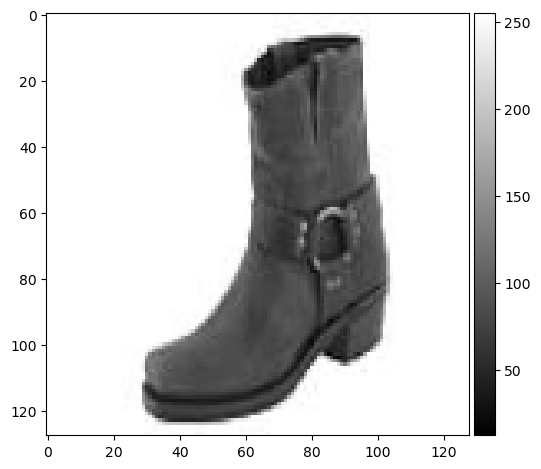

In [ ]:
def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')

  
# redefine datasets for use with sklearn filters => grayscale
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './footwear_data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

def fetch_all(ds, filter=None):
  imgs = []
  lbls = []
  for img, lbl in ds:
    img = img.numpy().squeeze()
    if filter is not None:
      img = filter(img)
    imgs.append(img.reshape(128*128)) # flatten the image into a vector
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(val_ds)
imgs, lbls = fetch_all(val_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)

#### 3.1.2.1 Raw data
First, we test a random forest model on the raw image data, just as with CNN. We use the default parameters of RandomForestClassifier (100 trees, no max depth, min. 1 sample per leaf)

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.9646    0.9656    0.9651      1017
           1     0.9629    0.9210    0.9415       987
           2     0.9239    0.9629    0.9430       996

    accuracy                         0.9500      3000
   macro avg     0.9505    0.9498    0.9499      3000
weighted avg     0.9505    0.9500    0.9500      3000



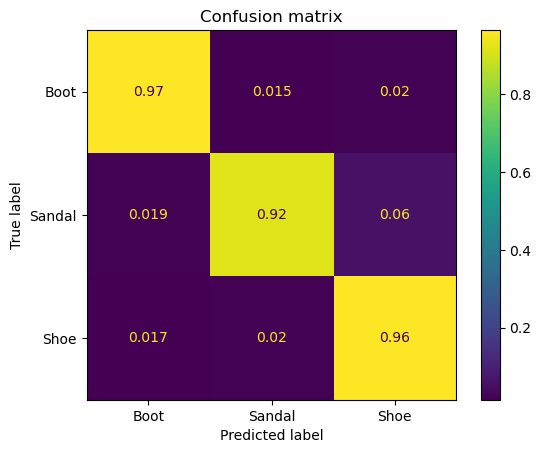

In [ ]:
train_x, train_y = fetch_all(train_ds)
test_x, test_y = fetch_all(val_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

We get a very high test score and a perfect training score, even without using any data augmentation (as opposed to used in the CNN) or hyperparameter tuning. This might be due to the simplicity of the dataset... We will investigate if we can improve upon this score even more by using edge detection filters.

#### 3.1.2.2 Sobel kernel
The sobel kernel is a 3x3 filter that is often used in edge detection. It calculates the approximate gradient of the image intensity function by using two 3x3 kernels that convolve the original image (one for x-axis, one for y-axis).

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


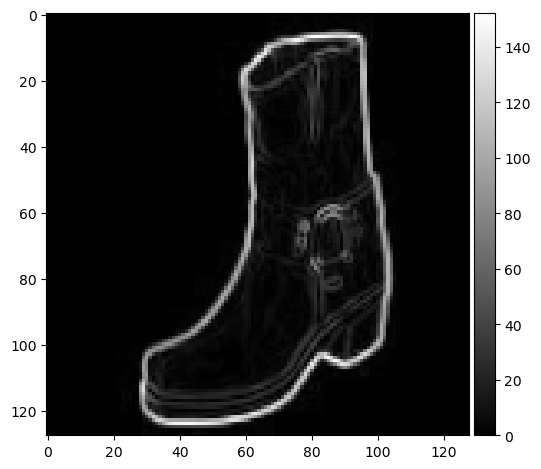

In [ ]:
from skimage import filters

img, lbl = fetch_sample(val_ds)
sobel_img = filters.sobel(img)

imshow(sobel_img, cmap='gray')


Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.9390    0.9538    0.9463      1017
           1     0.9457    0.8652    0.9037       987
           2     0.8844    0.9448    0.9136       996

    accuracy                         0.9217      3000
   macro avg     0.9230    0.9213    0.9212      3000
weighted avg     0.9231    0.9217    0.9214      3000



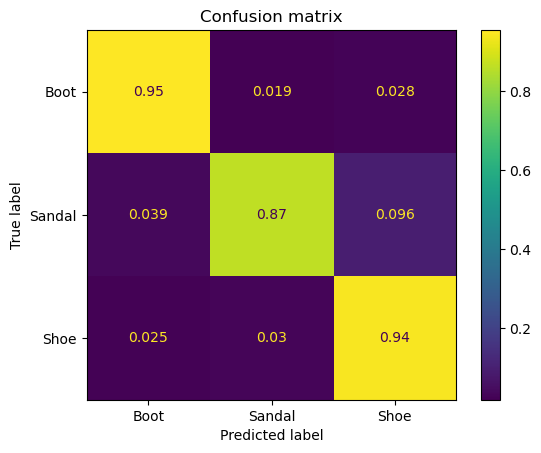

In [ ]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Again we get a very accurate model, but contrary to our expectations, test accuracy has dropped slightly when compared to training on raw data.

#### 3.1.2.3 Laplace operator
Another method for edge detection. In contrast to Sobel the 2nd derivative of the image intensity is computed. Instead of using 2 kernels it uses 1 symmetrical kernel. We investigate whether this impacts learning performance.


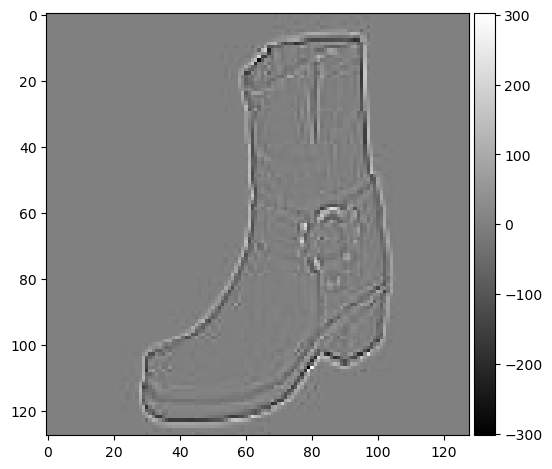

In [ ]:
img, lbl = fetch_sample(val_ds)
img = filters.laplace(img)

imshow(img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8744    0.9312    0.9019      1017
           1     0.8842    0.7042    0.7840       987
           2     0.7816    0.8876    0.8312       996

    accuracy                         0.8420      3000
   macro avg     0.8468    0.8410    0.8390      3000
weighted avg     0.8468    0.8420    0.8396      3000



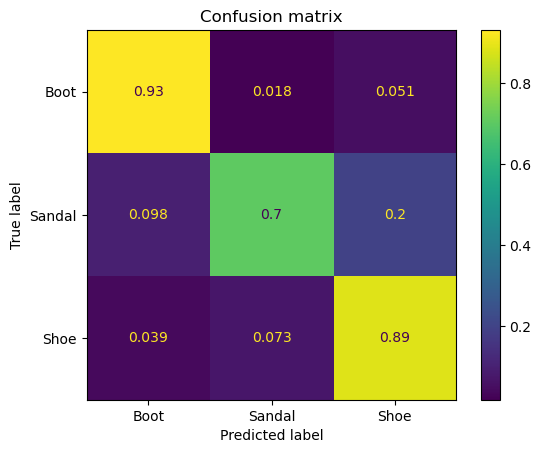

In [ ]:
train_x, train_y = fetch_all(train_ds, filters.laplace)
test_x, test_y = fetch_all(val_ds, filters.laplace)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using the Laplace operator model performance has dropped even more compared to training on raw data and using the Sobel kernel. Especially the amount of misclassifications of sandals as shoes has increased.

For now we can conclude that on a simple dataset such as the footwear set we used, CNNs outperform simple manual feature extraction methods in combination with random forest classification. However, [more complicated techniques](https://ceur-ws.org/Vol-2320/short7.pdf) exist that involve changing the color space from rgb to the l\*a\*b\* scheme.

In order to explain the surprisingly high performance on raw image data, we can reason that it might be possible that the model learns to predict the footwear classes solely based on what pixels are lit up. This method could work due to the uniformity of samples in the dataset (same brightness, average position of footwear, orientation of footwear) In order to test this, we will resume with a more complex dataset for our subsequent experiments.

## 3.2 Muffin vs Chihuaha image dataset
Because we suspect that previous dataset gave the model opportunity to learn pixel locations 'by heart', we will use the same image data set as used in 1.6. We can compare the random forest classifier's results with the results of the CNN used in that section. It had an accuracy of 0.94 and an F1-score of 0.93.

Note that the classes are not entirely balanced with a ratio of 1.18 chihuahuas/muffin

### Loading the dataset

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(1184, 4096)
(1184,)
['chihuahua', 'muffin']


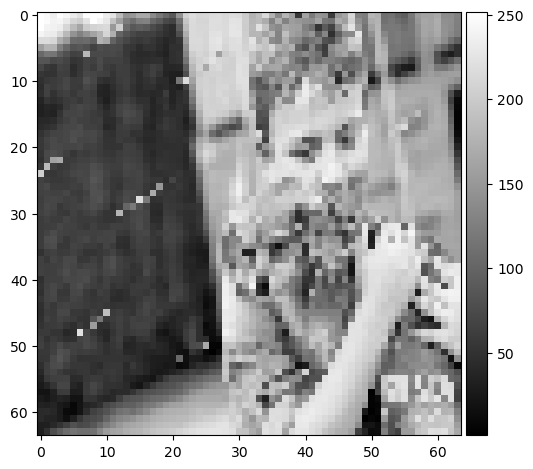

In [ ]:
def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["chihuaha" , "muffin"]).plot()
    disp.ax_.set_title('Confusion matrix')

  
train_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/train',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(64, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)
test_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/test',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(64, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

def fetch_all(ds, filter=None):
  imgs = []
  lbls = []
  for img, lbl in ds:
    img = img.numpy().squeeze()
    if filter is not None:
      img = filter(img)
    imgs.append(img.reshape(64*64)) # flatten the image into a vector
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(test_ds)
imgs, lbls = fetch_all(test_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)
print(train_ds.class_names)

### 3.2.1 Raw data
Train a decision tree on the raw data. We do not expect this to yield very accurate results due to the variety of images present in the data set.

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8149    0.7359    0.7734       640
           1     0.7211    0.8033    0.7600       544

    accuracy                         0.7669      1184
   macro avg     0.7680    0.7696    0.7667      1184
weighted avg     0.7718    0.7669    0.7672      1184



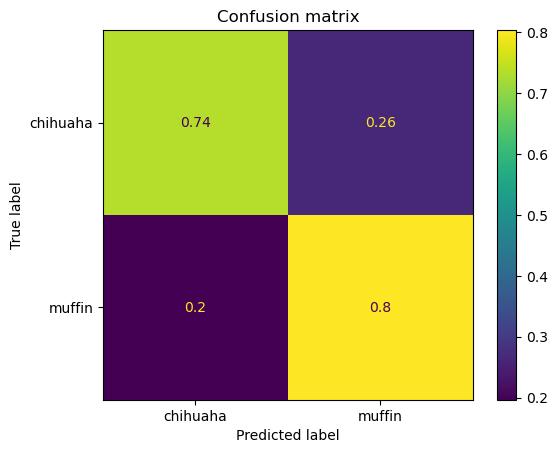

In [ ]:
train_x, train_y = fetch_all(train_ds)
test_x, test_y = fetch_all(test_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

The results are better than expected initially. Test accuracy is around 77%.

### 3.2.2 Sobel Kernel

Apply the Sobel kernel to observe its impact on learning.

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


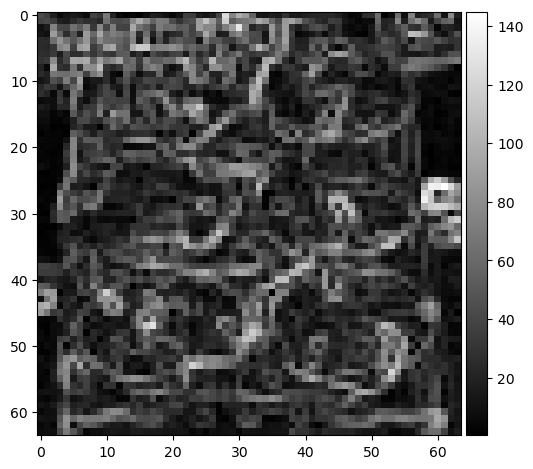

In [ ]:
img, lbl = fetch_sample(test_ds)
sobel_img = filters.sobel(img)

imshow(sobel_img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8463    0.7656    0.8039       640
           1     0.7521    0.8364    0.7920       544

    accuracy                         0.7981      1184
   macro avg     0.7992    0.8010    0.7980      1184
weighted avg     0.8030    0.7981    0.7984      1184



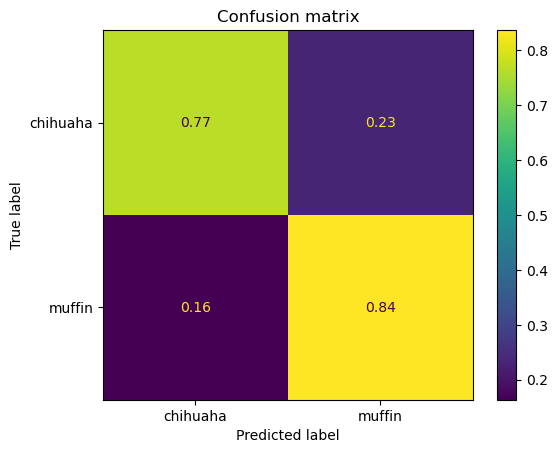

In [ ]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(test_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using Sobel kernel for edge detection, the model is able to achieve an accuracy of around 80%. Misclassifications of both muffins and dogs have been reduced.

### 3.2.3 Laplace operator

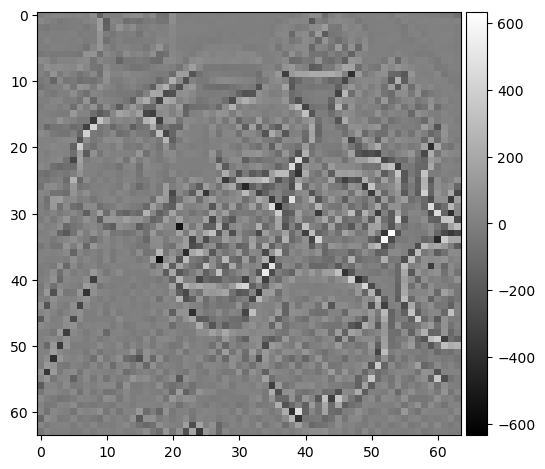

In [ ]:
img, lbl = fetch_sample(test_ds)
img = filters.laplace(img)

imshow(img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8340    0.6984    0.7602       640
           1     0.7022    0.8364    0.7634       544

    accuracy                         0.7618      1184
   macro avg     0.7681    0.7674    0.7618      1184
weighted avg     0.7734    0.7618    0.7617      1184



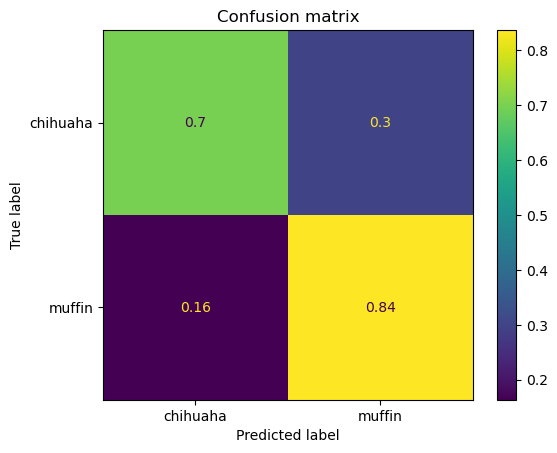

In [ ]:
train_x, train_y = fetch_all(train_ds, filters.laplace)
test_x, test_y = fetch_all(test_ds, filters.laplace)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using the Laplace operator, accuracy drops to around 77%. Notably, the ratio of misclassified chihuahuas increased while the ratio of misclassified muffins remained the same as with the Sobel kernel.

### 3.2.4 Model tuning using Sobel kernel
Try to tune the Sobel kernel random forest model hyperparameters using gridsearchCV.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .....................................max_depth=None; total time=  14.5s
[CV] END .....................................max_depth=None; total time=  15.2s
[CV] END .....................................max_depth=None; total time=  14.3s
[CV] END .....................................max_depth=None; total time=  14.5s
[CV] END .....................................max_depth=None; total time=  15.7s
[CV] END .......................................max_depth=10; total time=  12.7s
[CV] END .......................................max_depth=10; total time=  13.0s
[CV] END .......................................max_depth=10; total time=  13.1s
[CV] END .......................................max_depth=10; total time=  12.3s
[CV] END .......................................max_depth=10; total time=  12.5s
[CV] END .......................................max_depth=20; total time=  15.5s
[CV] END .......................................m

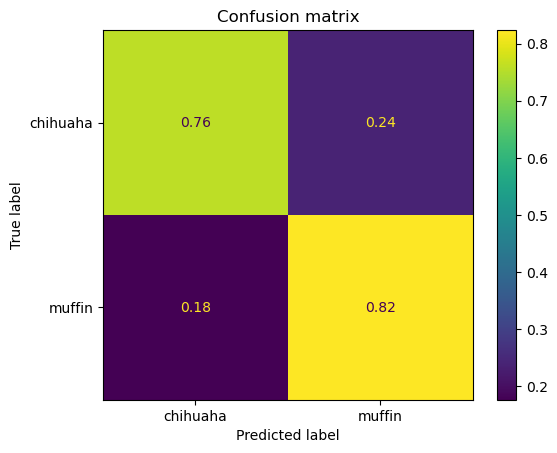

In [ ]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(test_ds, filters.sobel)

rf_model = RandomForestClassifier()

model = GridSearchCV(rf_model, {'max_depth': [None, 10, 20, 30, 50]}, verbose=2)
model.fit(train_x, train_y)

y_pred = model.predict(test_x)
y_pred_train = model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

In [ ]:
print(model.best_params_)

{'max_depth': None}


The default max_depth hyperparameter of random forest is best set to None.

### 3.2.5 Histogram of Gradients (HOG)
HOG is a feature extraction pipeline that was originally used to recognize pedestrians. It works as follows:
- The pixel intensity gradient is calculated (Sobel filter)
- The histogram for the grid cells on the image is calculated
- Normalize across histogram blocks
- The features determined by the histogram can be used for classification 

In the [paper](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf), the optimal image size is 128*64 so we will use that size. Also 9 bins are used.

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
(1184, 8192)
(1184,)
['chihuahua', 'muffin']


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


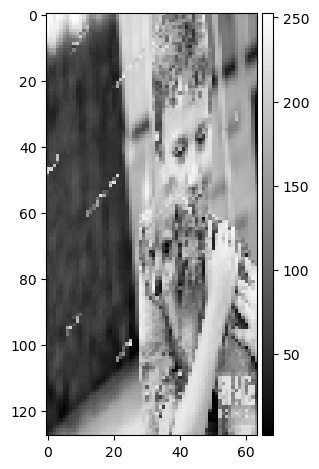

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/train',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(128, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)
test_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/test',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(128, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

# returns all HOG features from a dataset
def fetch_all_hog(ds):
  imgs = []
  lbls = []
  for img, lbl in ds:
    hog_feat = feature.hog(img)
    imgs.append(hog_feat)
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(test_ds)
imgs, lbls = fetch_all(test_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)
print(train_ds.class_names)

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


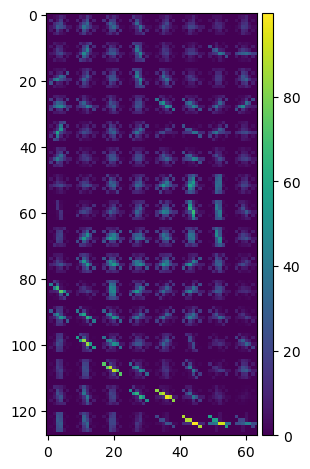

In [ ]:
img, _ = fetch_sample(test_ds)
HOG, viz = feature.hog(img, visualize=True)
imshow(viz)

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.7958    0.8281    0.8116       640
           1     0.7876    0.7500    0.7684       544

    accuracy                         0.7922      1184
   macro avg     0.7917    0.7891    0.7900      1184
weighted avg     0.7921    0.7922    0.7918      1184



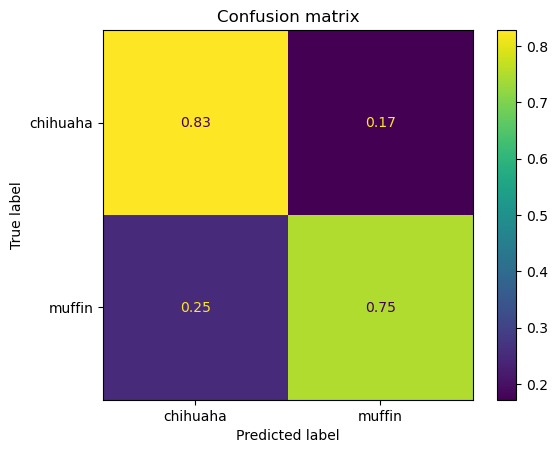

In [ ]:
train_x, train_y = fetch_all_hog(train_ds)
test_x, test_y = fetch_all_hog(test_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

We have a slightly lower accuracy than when using Sobel filtering. The ratios of misclassified muffins and chihuahuas are respectively higher and lower than when using Sobel. This might be due to the way that features are represented in HOG.

## 3.3 Results & Conclusion
### 3.3.1 Results
| Accuracy | CNN | Random Forest (RF) | RF + Sobel | RF + Laplace | RF + HOG |
| --- | --- | --- | --- | --- | ---|
| Footwear catalog | 0.90 | 0.95 | 0.92 | 0.85 | \ |
| Muffins & Dogs | 0.94 | 0.77 | 0.80 | 0.77 | 0.79 |  
### 3.3.2 Conclusion
From our experiments on the footwear dataset we can clearly see that simple ML methods can approximate CNN performance in a scenario of image classification, where images are very uniform in terms of the position, orientation and shape of the object to be classified. The accuracy of our CNN are even worse than those of the random forest classifier on the raw data (however better performance should be achievable for CNN). This means that in the case of image recognizition for a catalog of items in a shop, where most items are similarly photgraphed, training of a CNN is not always necessary. Training a CNN can be time-consuming process (ours took around 120 mins.), while training our random forest can be done in under 10 mins. Training times also increase with the amount of classes and samples so for complex problems this difference will only grow. Also, the sample efficiency of the random forest is better compared to CNN: looking at the accuracy/epoch in the graph in 3.1.1, CNN required 8 epochs (= passes through whole training set) to get to its accuracy of 90%, while random forest requires only 1.

During our experiments on the muffins vs chihuahuas dataset, we noticed that the CNN consistently outperformed our feature extraction techniques + random forest. We can accredit this to the more complex imagery in the dataset. Even though the accuracy is worse at around 10% less, it is still not bad and improvement could be made using more complicated feature extraction techniques such as [SIFT](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.SIFT), [FCTH](https://ieeexplore.ieee.org/document/4556917) or [ORB](https://iopscience.iop.org/article/10.1088/1742-6596/1237/3/032020/pdf).